# ***Introduction***

In [ ]:
!pip install torchmetrics==0.11.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 1.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import torchmetrics

from tqdm.auto import tqdm #Progress bar

import pandas as pd

import random

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from typing import Dict, List

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Setup training data
train_data = datasets.CIFAR10(
    root="data",
    train=True, #get training data
    download=True,
    transform=transform,
)

# Setup testing data
test_data = datasets.CIFAR10(
    root="data",
    train=False, # get testing data
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:05<00:00, 30.4MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# First training sample
image, label = train_data[0]
image, label

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [ ]:
image.shape
# the first number is a 3 which means that the picture has RGB colours (1 means the picture has greyscale colours)
# 32 is the width of the picture and 32 is the height of the picture, so the picture has 32*32 = 1024 pixels

torch.Size([3, 32, 32])

In [ ]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)
# 50000 training sample, 10000 testing sample

(50000, 50000, 10000, 10000)

In [ ]:
# classes in the dataset
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

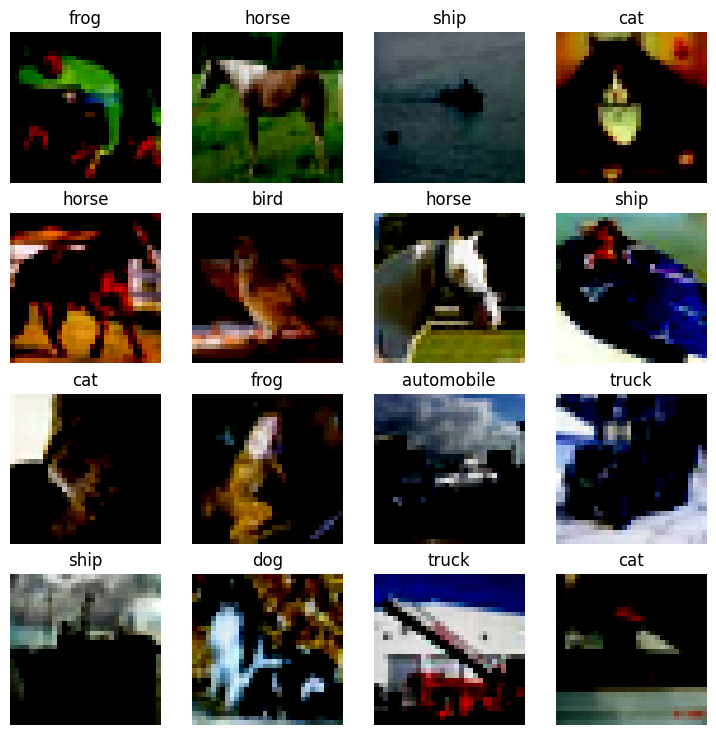

In [ ]:
# Plotting some pictures
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1,2,0)) # (C,H,W) to (H,W,C), so the input order is correct
    plt.title(class_names[label])
    plt.axis(False);

In [ ]:
# DataLoader

batch_size = 32 # this is a hyperparameter

train_dataloader = DataLoader(train_data,
    batch_size=batch_size,
    shuffle=True # shuffels the data in every epoch
)

test_dataloader = DataLoader(test_data,
    batch_size=batch_size,
    shuffle=False
)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32


# ***# Model_0 (Basic starting point)***
Simple neural network with 2 linear layers

Testing 6 different cases, then analyzing the results

hidden_units (number of neurons):32 (small) vagy 128 (medium) vagy 512 (large)

lr (learning rate): 0,1 vagy 0,01

In [ ]:
class CIFAR10ModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),# converts the image input to vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of input pixels; hidden_units = neurons of hidden layer (hyperparameter)
            nn.Linear(in_features=hidden_units, out_features=output_shape) #output_shape = number of classes, because every class needs an output neuron
        )

    def forward(self, x):
        return self.layer_stack(x)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Training function (can be used later)
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device,
               results:dict = None):

    train_loss, train_acc = 0, 0
    model.to(device) # moves to GPU, if it is avaibale
    accuracy_fn.to(device) # moves to GPU, if it is avaibale

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device) # moves to GPU, if it is avaibale

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (for every batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # cumulative value for every epoch
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Defining and assigning values
    train_loss /= len(data_loader)
    train_acc = (train_acc/len(data_loader))*100

    if results is not None:
        results["train_loss"].append(train_loss.item())
        results["train_acc"].append(train_acc)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    return train_loss, train_acc

# Testing function (can be used later)
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device,
              results: dict = None):

    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # model goes to evaluating mode
    accuracy_fn.to(device) # moves to GPU, if it is avaibale

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y) # cumulative value for every epoch
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

        # Defining and assigning values
        test_loss /= len(data_loader)
        test_acc = (test_acc/len(data_loader))*100

        if results is not None:
            results["test_loss"].append(test_loss.item())
            results["test_acc"].append(test_acc)

        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss, test_acc

# Evaluating function, which can be used later (we get a dictionary with the results of the model)
def eval_model(model: torch.nn.Module, # predictiont készít
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1),y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc.item()*100}

def plot_curves(results: Dict[str, List[float]]):


    # Get the loss values of the results dictionary (training and test)
    loss = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in results['train_loss']]  # Convert to NumPy and move to CPU if necessary
    test_loss = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in results['test_loss']]  # Convert to NumPy and move to CPU if necessary

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in results['train_acc']]  # Convert to NumPy and move to CPU if necessary
    test_accuracy = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in results['test_acc']]  # Convert to NumPy and move to CPU if necessary

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

# ***Model_0_1 (32 neurons and 0.1 learning rate)***

In [ ]:
# Input parameters must be given
Model_0_1 = CIFAR10ModelV0(input_shape=3072, # 3*32*32 = 3072 (3 because of RGB * number of pixels)
    hidden_units=32,
    output_shape=len(class_names)
)
Model_0_1.to(device) # Move model to GPU if it is avaiable


#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device) # this is moved to GPU, if it is avaiable
loss_fn = nn.CrossEntropyLoss() # this is good for this problem
optimizer = torch.optim.SGD(params=Model_0_1.parameters(), lr=0.1) #optimizer to update the weights with the chosen learning rate

torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_0_1 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_0_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_1
    )
    test_step(data_loader=test_dataloader,
        model=Model_0_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_1
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.85881 | Train accuracy: 34.33%
Test loss: 1.92263 | Test accuracy: 34.49%

Epoch: 1
-------
Train loss: 1.80767 | Train accuracy: 36.99%
Test loss: 1.78788 | Test accuracy: 37.49%

Epoch: 2
-------
Train loss: 1.78962 | Train accuracy: 37.98%
Test loss: 1.80769 | Test accuracy: 37.06%



In [ ]:
# Results of Model_0_1
Model_0_1_results = eval_model(model=Model_0_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_0_1_results

{'model_name': 'CIFAR10ModelV0',
 'model_loss': 1.807687520980835,
 'model_acc': 37.060701847076416}

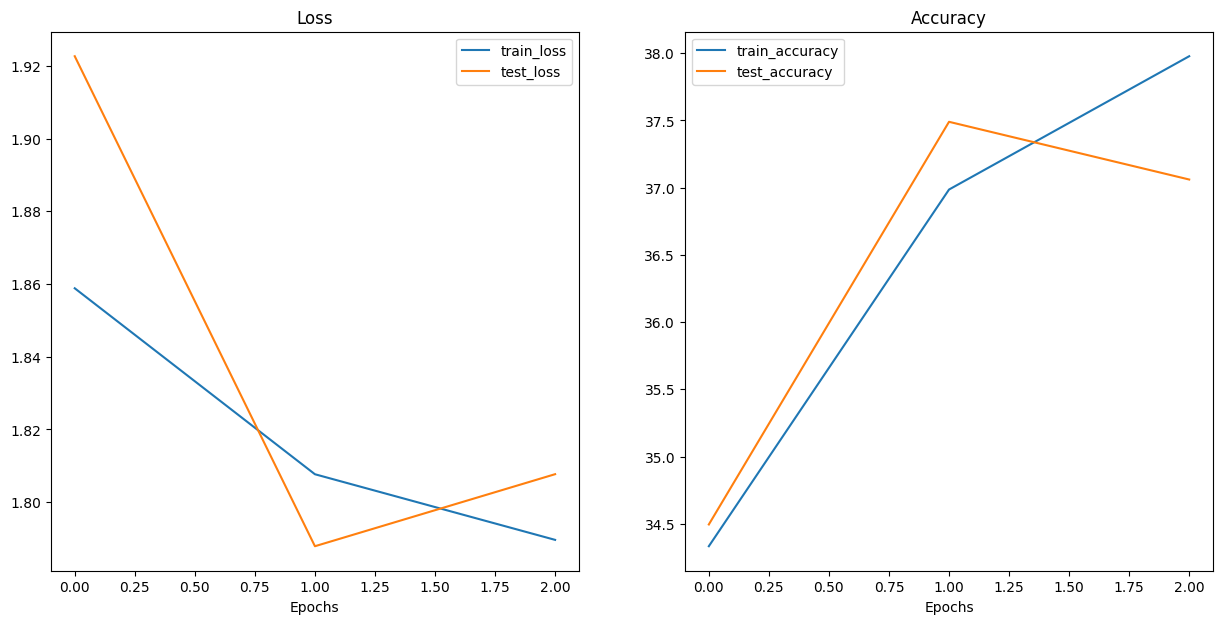

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_0_1)

# ***Model_0_2 (32 neurons and 0,01 learning rate)***

In [ ]:
# Input parameters must be given
Model_0_2 = CIFAR10ModelV0(input_shape=3072, # 3*32*32 = 3072 (3 because of RGB * number of pixels)
    hidden_units=32,
    output_shape=len(class_names)
)
Model_0_2.to(device) # Move model to GPU if it is avaiable


#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device) # this is moved to GPU, if it is avaiable
loss_fn = nn.CrossEntropyLoss() # this is good for this problem
optimizer = torch.optim.SGD(params=Model_0_2.parameters(), lr=0.01) #optimizer to update the weights with the chosen learning rate

torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_0_2 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_0_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_2
    )
    test_step(data_loader=test_dataloader,
        model=Model_0_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_2
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.83557 | Train accuracy: 36.67%
Test loss: 1.76828 | Test accuracy: 37.96%

Epoch: 1
-------
Train loss: 1.74262 | Train accuracy: 40.12%
Test loss: 1.73013 | Test accuracy: 39.80%

Epoch: 2
-------
Train loss: 1.71810 | Train accuracy: 40.95%
Test loss: 1.72173 | Test accuracy: 40.33%



In [ ]:
# Results of Model_0_2
Model_0_2_results = eval_model(model=Model_0_2, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_0_2_results

{'model_name': 'CIFAR10ModelV0',
 'model_loss': 1.721730351448059,
 'model_acc': 40.325477719306946}

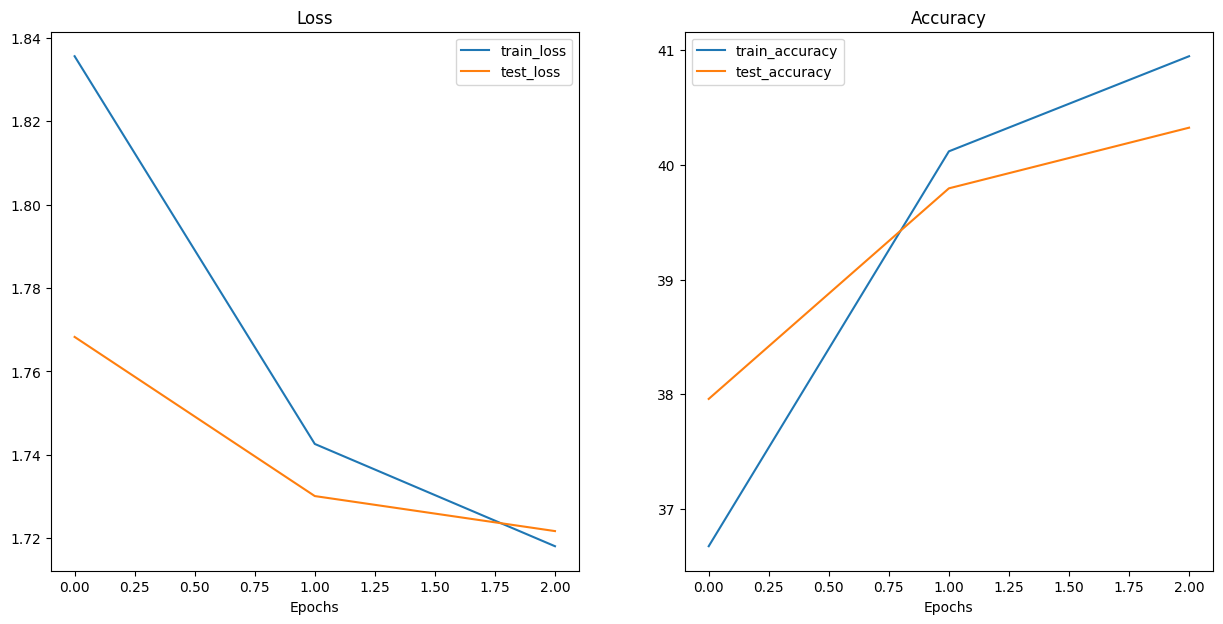

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_0_2)

# ***Model_0_3 (128 neurons and 0,1 learning rate)***

In [ ]:
# Input parameters must be given
Model_0_3 = CIFAR10ModelV0(input_shape=3072, # 3*32*32 = 3072 (3 because of RGB * number of pixels)
    hidden_units=128,
    output_shape=len(class_names)
)
Model_0_3.to(device) # Move model to GPU if it is avaiable


#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device) # this is moved to GPU, if it is avaiable
loss_fn = nn.CrossEntropyLoss() # this is good for this problem
optimizer = torch.optim.SGD(params=Model_0_3.parameters(), lr=0.1) #optimizer to update the weights with the chosen learning rate

torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_0_3 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_0_3,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_3
    )
    test_step(data_loader=test_dataloader,
        model=Model_0_3,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_3
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.85998 | Train accuracy: 34.39%
Test loss: 1.92818 | Test accuracy: 34.69%

Epoch: 1
-------
Train loss: 1.80929 | Train accuracy: 36.85%
Test loss: 1.78865 | Test accuracy: 37.68%

Epoch: 2
-------
Train loss: 1.79133 | Train accuracy: 37.84%
Test loss: 1.80663 | Test accuracy: 37.24%



In [ ]:
# Results of Model_0_3
Model_0_3_results = eval_model(model=Model_0_3, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_0_3_results

{'model_name': 'CIFAR10ModelV0',
 'model_loss': 1.8066332340240479,
 'model_acc': 37.240415811538696}

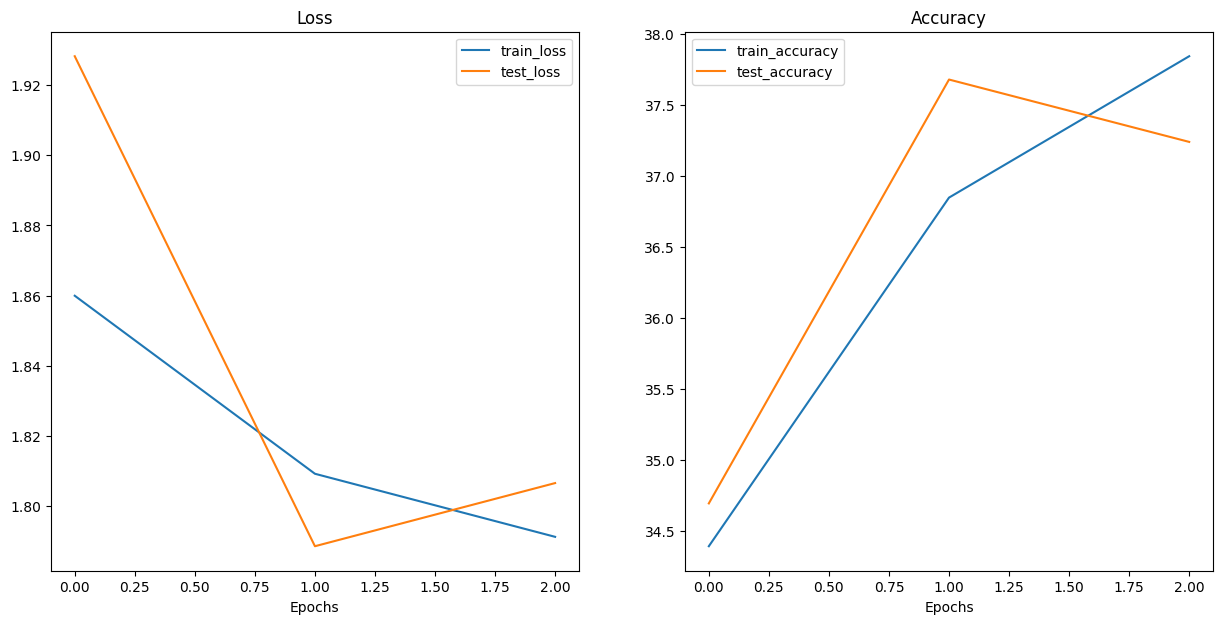

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_0_3)

# ***Model_0_4 (128 neurons and 0,01 learning rate)***

In [ ]:
# Input parameters must be given
Model_0_4 = CIFAR10ModelV0(input_shape=3072, # 3*32*32 = 3072 (3 because of RGB * number of pixels)
    hidden_units=128,
    output_shape=len(class_names)
)
Model_0_4.to(device) # Move model to GPU if it is avaiable


#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device) # this is moved to GPU, if it is avaiable
loss_fn = nn.CrossEntropyLoss() # this is good for this problem
optimizer = torch.optim.SGD(params=Model_0_4.parameters(), lr=0.01) #optimizer to update the weights with the chosen learning rate

torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_0_4 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_0_4,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_4
    )
    test_step(data_loader=test_dataloader,
        model=Model_0_4,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_4
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.83429 | Train accuracy: 36.67%
Test loss: 1.76696 | Test accuracy: 38.25%

Epoch: 1
-------
Train loss: 1.74336 | Train accuracy: 40.07%
Test loss: 1.72916 | Test accuracy: 40.35%

Epoch: 2
-------
Train loss: 1.71857 | Train accuracy: 40.83%
Test loss: 1.72083 | Test accuracy: 40.71%



In [ ]:
# Results of Model_0_4
Model_0_4_results = eval_model(model=Model_0_4, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_0_4_results

{'model_name': 'CIFAR10ModelV0',
 'model_loss': 1.7208319902420044,
 'model_acc': 40.71485698223114}

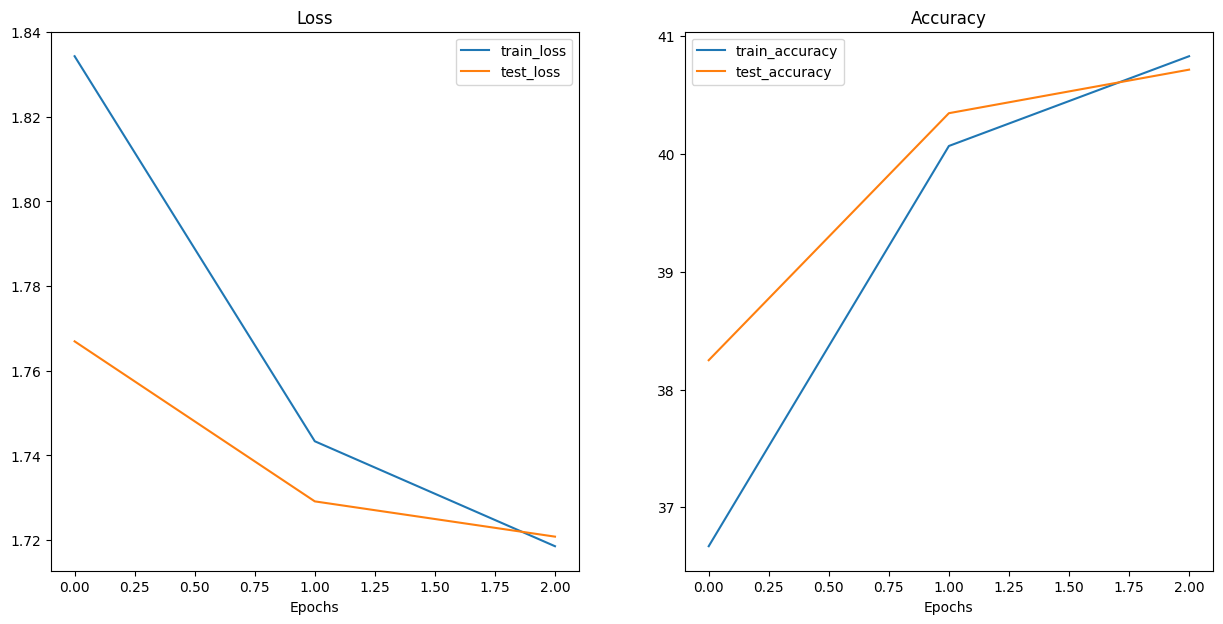

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_0_4)

# ***Model_0_5 (512 neurons and 0,1 learning rate)***

In [ ]:
# Input parameters must be given
Model_0_5 = CIFAR10ModelV0(input_shape=3072, # 3*32*32 = 3072 (3 because of RGB * number of pixels)
    hidden_units=512,
    output_shape=len(class_names)
)
Model_0_5.to(device) # Move model to GPU if it is avaiable


#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device) # this is moved to GPU, if it is avaiable
loss_fn = nn.CrossEntropyLoss() # this is good for this problem
optimizer = torch.optim.SGD(params=Model_0_5.parameters(), lr=0.1) #optimizer to update the weights with the chosen learning rate

torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_0_5 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_0_5,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_5
    )
    test_step(data_loader=test_dataloader,
        model=Model_0_5,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_5
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.86511 | Train accuracy: 34.28%
Test loss: 1.94564 | Test accuracy: 34.43%

Epoch: 1
-------
Train loss: 1.81462 | Train accuracy: 36.72%
Test loss: 1.79305 | Test accuracy: 37.64%

Epoch: 2
-------
Train loss: 1.79664 | Train accuracy: 37.71%
Test loss: 1.81096 | Test accuracy: 37.19%



In [ ]:
# Results of Model_0_5
Model_0_5_results = eval_model(model=Model_0_5, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_0_5_results

{'model_name': 'CIFAR10ModelV0',
 'model_loss': 1.8109567165374756,
 'model_acc': 37.19049394130707}

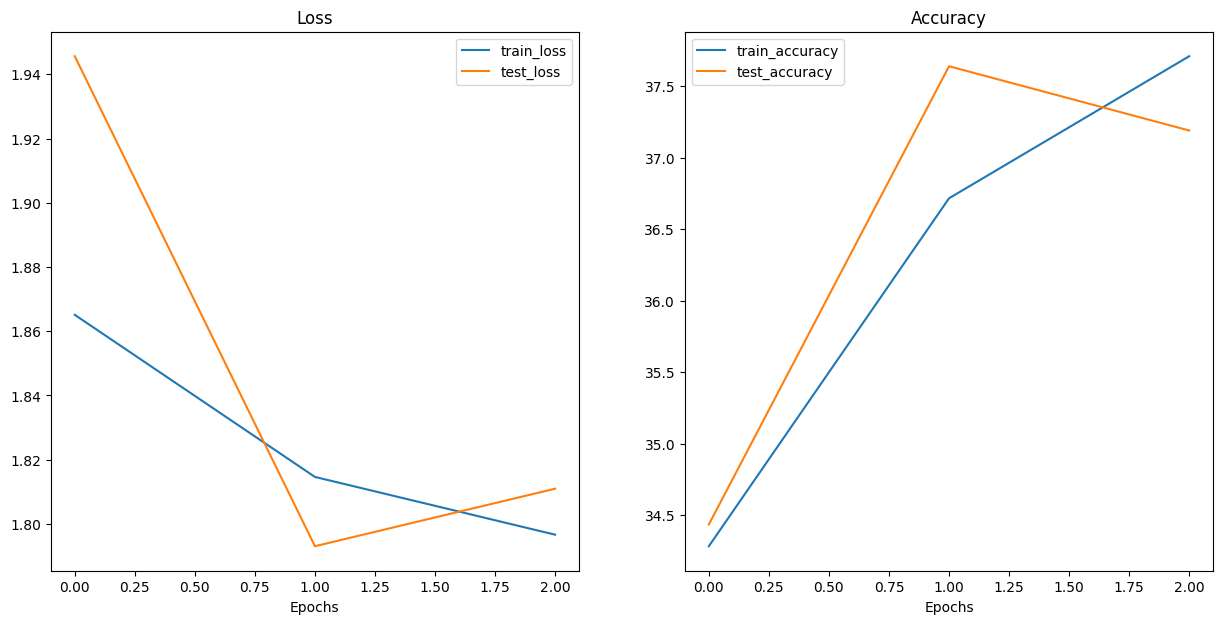

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_0_5)

# ***Model_0_6 (512 neurons and 0,01 learning rate)***

In [ ]:
# Input parameters must be given
Model_0_6 = CIFAR10ModelV0(input_shape=3072, # 3*32*32 = 3072 (3 because of RGB * number of pixels)
    hidden_units=512,
    output_shape=len(class_names)
)
Model_0_6.to(device) # Move model to GPU if it is avaiable


#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device) # this is moved to GPU, if it is avaiable
loss_fn = nn.CrossEntropyLoss() # this is good for this problem
optimizer = torch.optim.SGD(params=Model_0_6.parameters(), lr=0.01) #optimizer to update the weights with the chosen learning rate

torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_0_6 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_0_6,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_6
    )
    test_step(data_loader=test_dataloader,
        model=Model_0_6,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_0_6
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.82852 | Train accuracy: 36.93%
Test loss: 1.76515 | Test accuracy: 37.99%

Epoch: 1
-------
Train loss: 1.74065 | Train accuracy: 40.12%
Test loss: 1.72829 | Test accuracy: 40.06%

Epoch: 2
-------
Train loss: 1.71677 | Train accuracy: 40.97%
Test loss: 1.72109 | Test accuracy: 40.49%



In [ ]:
# Results of Model_0_6
Model_0_6_results = eval_model(model=Model_0_6, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_0_6_results

{'model_name': 'CIFAR10ModelV0',
 'model_loss': 1.7210909128189087,
 'model_acc': 40.48522412776947}

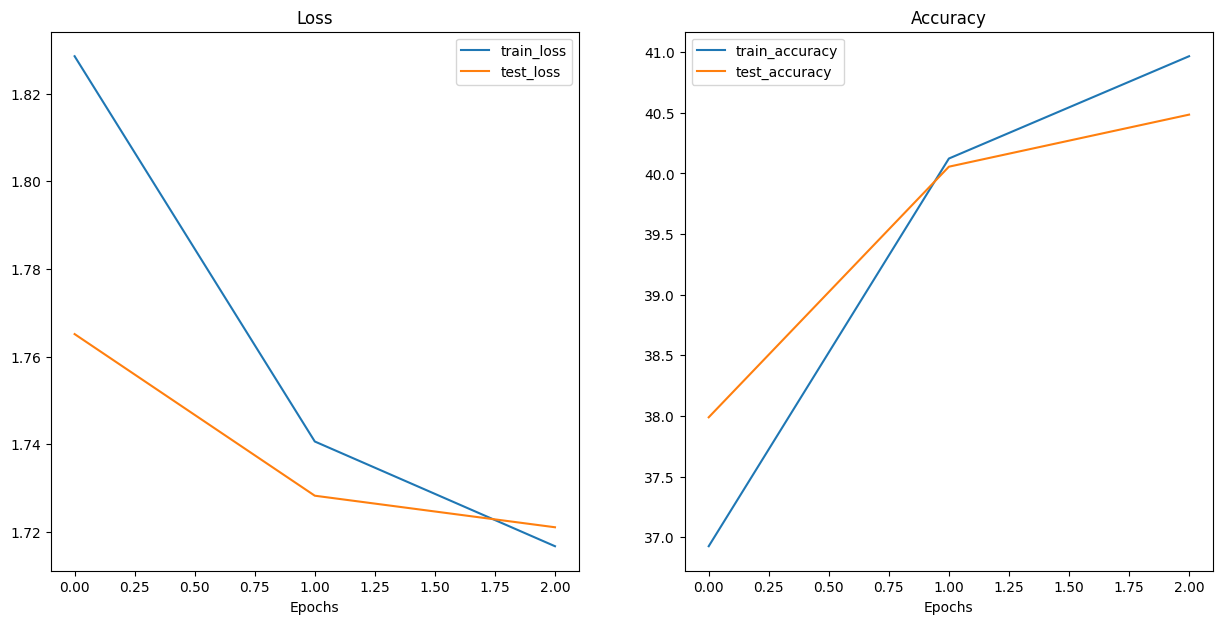

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_0_6)

# ***Comparing the results of Model_0***

In [ ]:
compare_results = pd.DataFrame([Model_0_1_results, Model_0_2_results, Model_0_3_results, Model_0_4_results, Model_0_5_results, Model_0_6_results])
compare_results

,model_name,model_loss,model_acc
0,CIFAR10ModelV0,1.807688,37.060702
1,CIFAR10ModelV0,1.721730,40.325478
2,CIFAR10ModelV0,1.806633,37.240416
3,CIFAR10ModelV0,1.720832,40.714857
4,CIFAR10ModelV0,1.810957,37.190494
5,CIFAR10ModelV0,1.721091,40.485224


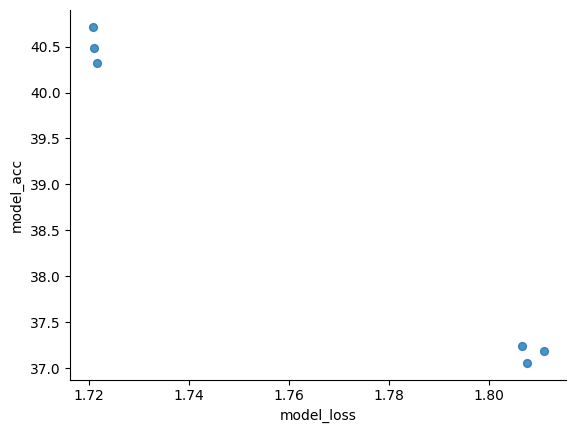

In [ ]:
compare_results.plot(kind='scatter', x='model_loss', y='model_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

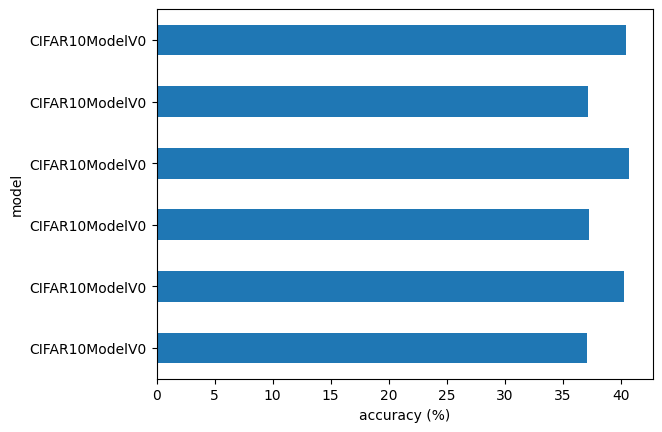

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

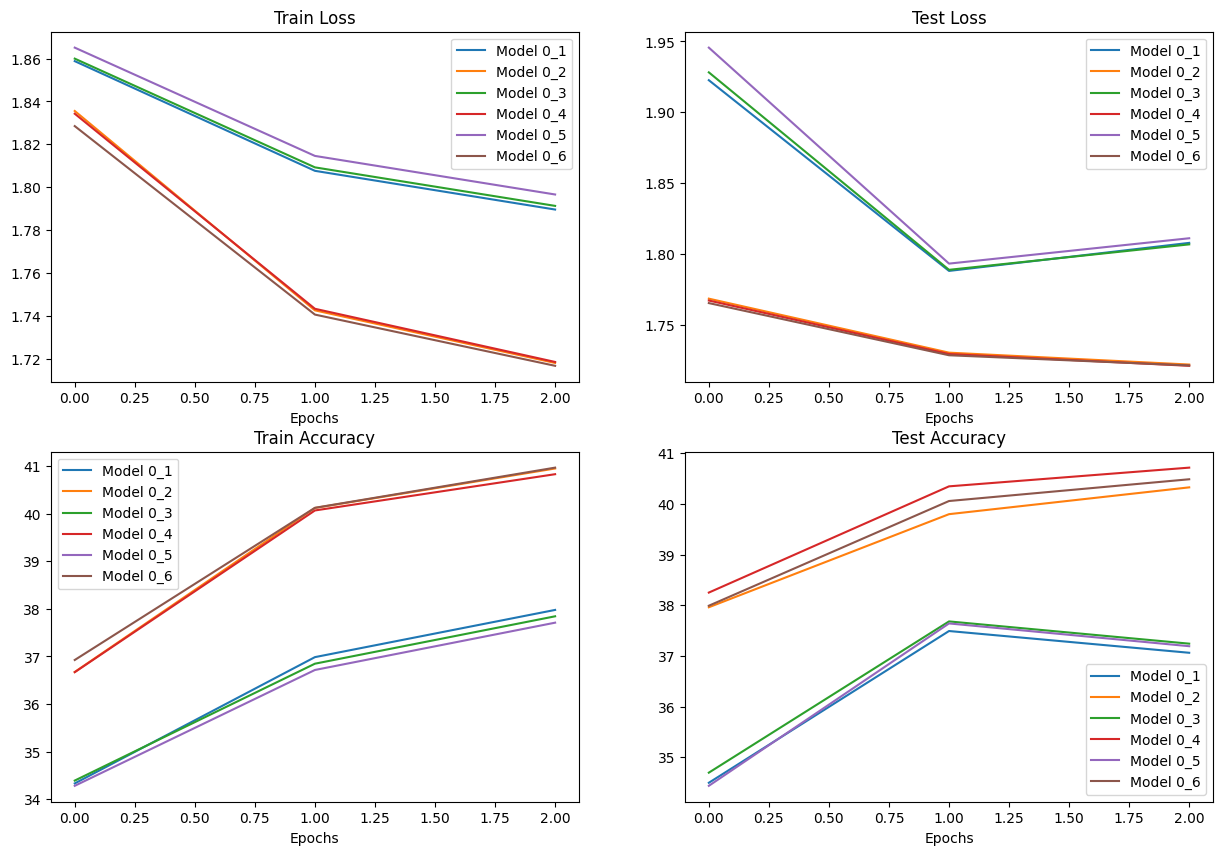

In [ ]:
# Recursively moving tensors in nested structures to the CPU
def move_to_cpu(x):
  if isinstance(x, torch.Tensor):
    return x.cpu().numpy()
  elif isinstance(x, (list, tuple)):
    return type(x)(move_to_cpu(item) for item in x)
  elif isinstance(x, dict):
    return {k: move_to_cpu(v) for k, v in x.items()}
  else:
    return x

Model_0_1_df = pd.DataFrame(move_to_cpu(results_0_1)) # Applying the function for moving here
Model_0_2_df = pd.DataFrame(move_to_cpu(results_0_2))
Model_0_3_df = pd.DataFrame(move_to_cpu(results_0_3))
Model_0_4_df = pd.DataFrame(move_to_cpu(results_0_4))
Model_0_5_df = pd.DataFrame(move_to_cpu(results_0_5))
Model_0_6_df = pd.DataFrame(move_to_cpu(results_0_6))

# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(Model_0_1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, Model_0_1_df["train_loss"], label="Model 0_1")
plt.plot(epochs, Model_0_2_df["train_loss"], label="Model 0_2")
plt.plot(epochs, Model_0_3_df["train_loss"], label="Model 0_3")
plt.plot(epochs, Model_0_4_df["train_loss"], label="Model 0_4")
plt.plot(epochs, Model_0_5_df["train_loss"], label="Model 0_5")
plt.plot(epochs, Model_0_6_df["train_loss"], label="Model 0_6")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, Model_0_1_df["test_loss"], label="Model 0_1")
plt.plot(epochs, Model_0_2_df["test_loss"], label="Model 0_2")
plt.plot(epochs, Model_0_3_df["test_loss"], label="Model 0_3")
plt.plot(epochs, Model_0_4_df["test_loss"], label="Model 0_4")
plt.plot(epochs, Model_0_5_df["test_loss"], label="Model 0_5")
plt.plot(epochs, Model_0_6_df["test_loss"], label="Model 0_6")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, Model_0_1_df["train_acc"], label="Model 0_1")
plt.plot(epochs, Model_0_2_df["train_acc"], label="Model 0_2")
plt.plot(epochs, Model_0_3_df["train_acc"], label="Model 0_3")
plt.plot(epochs, Model_0_4_df["train_acc"], label="Model 0_4")
plt.plot(epochs, Model_0_5_df["train_acc"], label="Model 0_5")
plt.plot(epochs, Model_0_6_df["train_acc"], label="Model 0_6")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, Model_0_1_df["test_acc"], label="Model 0_1")
plt.plot(epochs, Model_0_2_df["test_acc"], label="Model 0_2")
plt.plot(epochs, Model_0_3_df["test_acc"], label="Model 0_3")
plt.plot(epochs, Model_0_4_df["test_acc"], label="Model 0_4")
plt.plot(epochs, Model_0_5_df["test_acc"], label="Model 0_5")
plt.plot(epochs, Model_0_6_df["test_acc"], label="Model 0_6")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# ***Model_1(Introducing non-linearity)***
A more complex neural network with several layers (2 or 3 or 4)

Testing 6 different cases, then analyzing the results

hidden_units (number of neurons):[64,32]; [128,64,32]; [256,128,64,32]

lr (learning rate): 0,1 vagy 0,01

In [ ]:
# 2 layers
class CIFAR10ModelV1_1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), # activation function
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# 3 layers
class CIFAR10ModelV1_2(nn.Module):
    def __init__(self, input_shape: int, hidden_units_1: int, hidden_units_2: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units_1),
            nn.ReLU(), # activation function
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_2, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# 4 layers
class CIFAR10ModelV1_3(nn.Module):
    def __init__(self, input_shape: int, hidden_units_1: int, hidden_units_2: int, hidden_units_3: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units_1),
            nn.ReLU(), # activation function
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_2, out_features=hidden_units_3),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_3, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# ***Model_1_1 (2 layers and lr=0,1)***



In [ ]:
# Input parameters
Model_1_1 = CIFAR10ModelV1_1(input_shape=3072,
    hidden_units=32,
    output_shape=len(class_names)
)
Model_1_1.to(device) # moves to GPU, if it is avaibale

#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_1_1.parameters(), lr=0.1)
torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_1_1 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_1_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_1
    )
    test_step(data_loader=test_dataloader,
        model=Model_1_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_1
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.86048 | Train accuracy: 35.01%
Test loss: 2.01994 | Test accuracy: 35.00%

Epoch: 1
-------
Train loss: 1.74566 | Train accuracy: 39.53%
Test loss: 1.75363 | Test accuracy: 39.75%

Epoch: 2
-------
Train loss: 1.69943 | Train accuracy: 41.47%
Test loss: 1.72731 | Test accuracy: 40.53%



In [ ]:
# Results of Model_1_1
Model_1_1_results = eval_model(model=Model_1_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_1_1_results

{'model_name': 'CIFAR10ModelV1_1',
 'model_loss': 1.7273097038269043,
 'model_acc': 40.52515923976898}

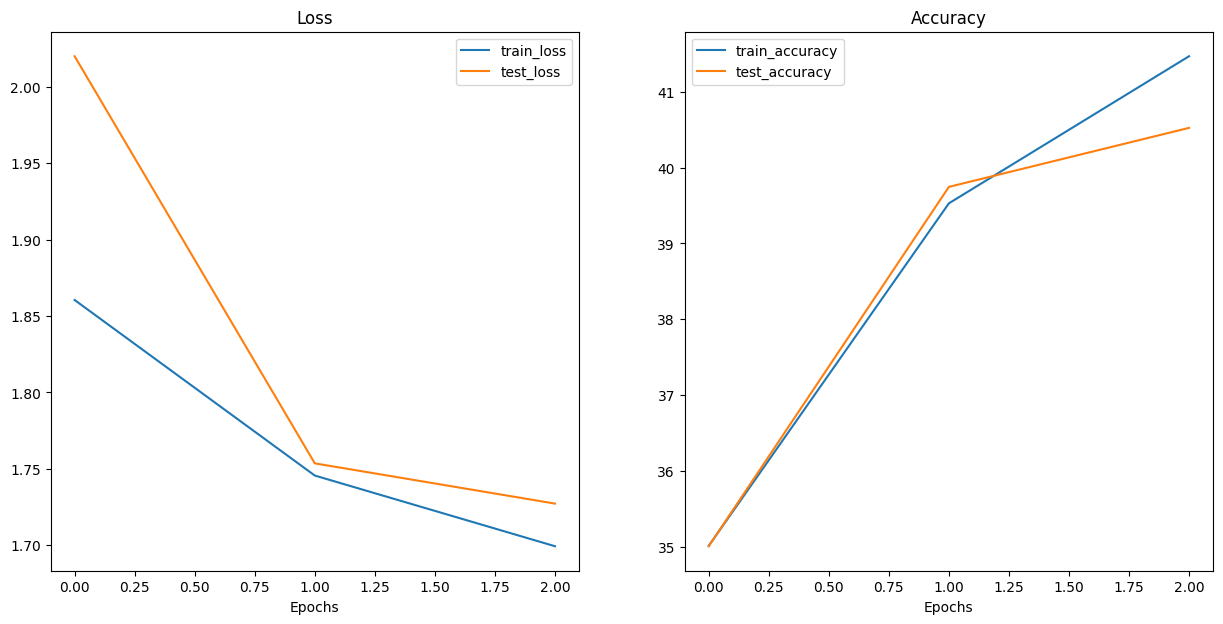

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_1_1)

# ***Model_1_2 (2 layers and lr=0,01)***

In [ ]:
# Input parameters
Model_1_2 = CIFAR10ModelV1_1(input_shape=3072,
    hidden_units=32,
    output_shape=len(class_names)
)
Model_1_2.to(device) # moves to GPU, if it is avaibale

#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_1_2.parameters(), lr=0.01)
torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_1_2 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_1_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_2
    )
    test_step(data_loader=test_dataloader,
        model=Model_1_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_2
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.85354 | Train accuracy: 35.67%
Test loss: 1.69091 | Test accuracy: 41.38%

Epoch: 1
-------
Train loss: 1.64741 | Train accuracy: 42.57%
Test loss: 1.61015 | Test accuracy: 43.78%

Epoch: 2
-------
Train loss: 1.57605 | Train accuracy: 45.13%
Test loss: 1.55854 | Test accuracy: 45.65%



In [ ]:
# Results of Model_1_2
Model_1_2_results = eval_model(model=Model_1_2, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_1_2_results

{'model_name': 'CIFAR10ModelV1_1',
 'model_loss': 1.558537244796753,
 'model_acc': 45.64696550369263}

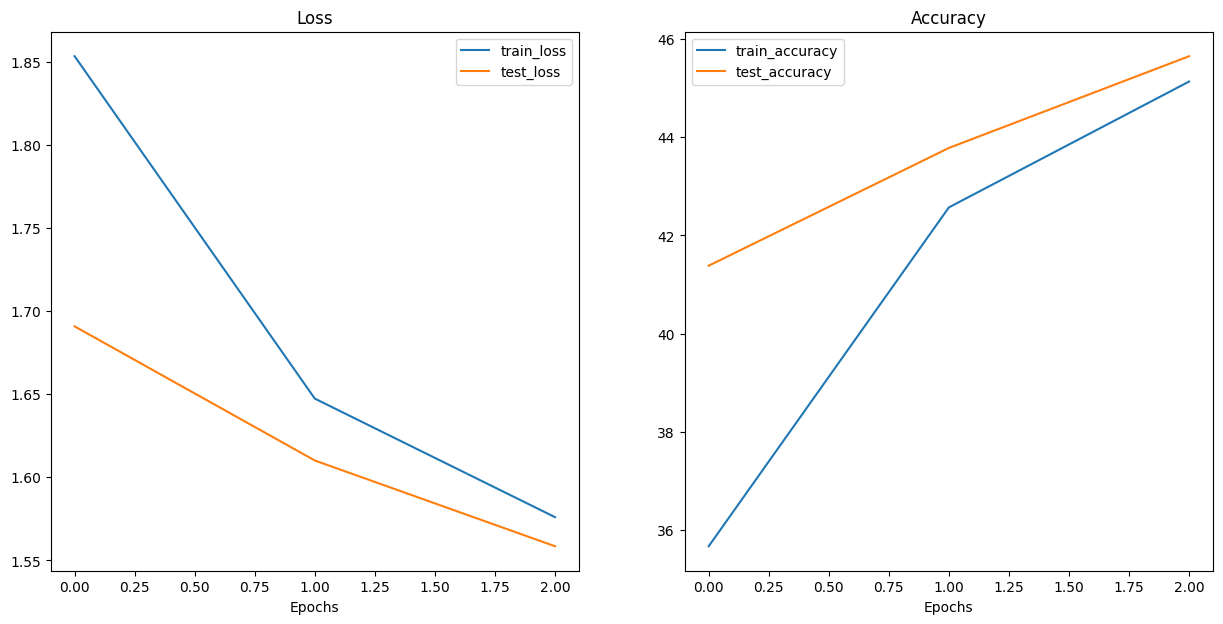

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_1_2)

# ***Model_1_3 (3 layers and lr=0,1)***

In [ ]:
# Input parameters
Model_1_3 = CIFAR10ModelV1_2(input_shape=3072,
    hidden_units_1 = 64,
    hidden_units_2 = 32,
    output_shape=len(class_names)
)
Model_1_3.to(device) # moves to GPU, if it is avaibale

#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_1_3.parameters(), lr=0.1)
torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_1_3 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_1_3,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_3
    )
    test_step(data_loader=test_dataloader,
        model=Model_1_3,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_3
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.79695 | Train accuracy: 36.70%
Test loss: 1.66552 | Test accuracy: 41.25%

Epoch: 1
-------
Train loss: 1.55583 | Train accuracy: 44.91%
Test loss: 1.54116 | Test accuracy: 46.14%

Epoch: 2
-------
Train loss: 1.47795 | Train accuracy: 47.75%
Test loss: 1.48152 | Test accuracy: 47.37%



In [ ]:
# Results of Model_1_3
Model_1_3_results = eval_model(model=Model_1_3, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_1_3_results

{'model_name': 'CIFAR10ModelV1_2',
 'model_loss': 1.4815192222595215,
 'model_acc': 47.37420082092285}

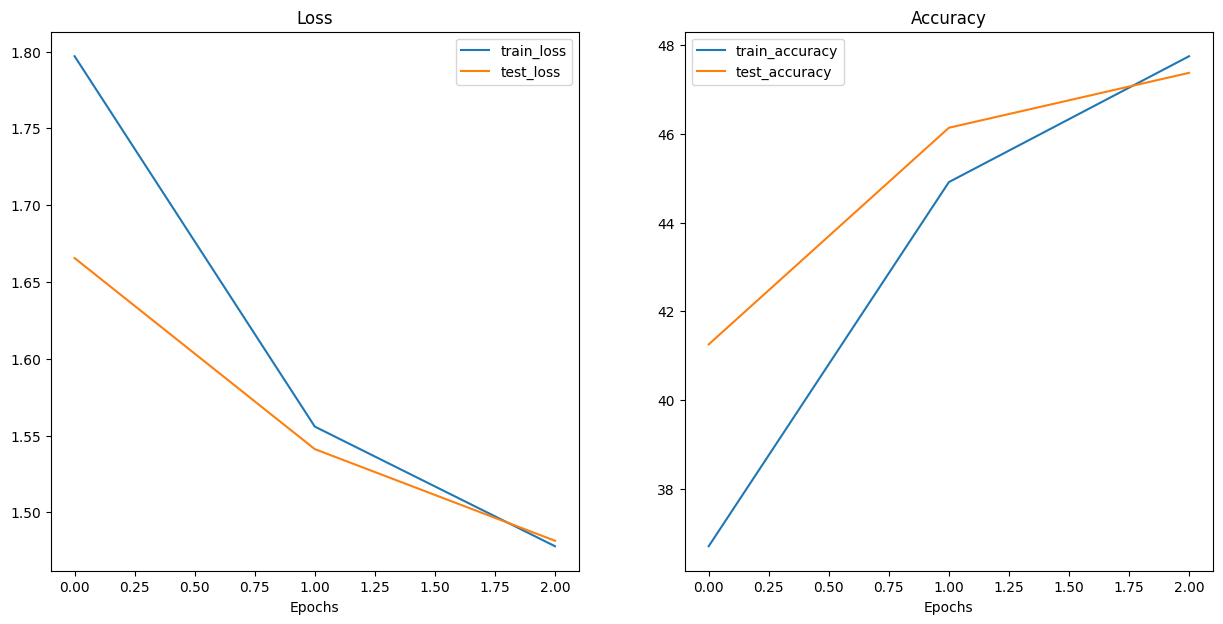

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_1_3)

# ***Model_1_4 (3 layers and lr=0,01)***

In [ ]:
# Input parameters
Model_1_4 = CIFAR10ModelV1_2(input_shape=3072,
    hidden_units_1 = 64,
    hidden_units_2 = 32,
    output_shape=len(class_names)
)
Model_1_4.to(device) # moves to GPU, if it is avaibale

#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_1_4.parameters(), lr=0.01)
torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_1_4 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_1_4,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_4
    )
    test_step(data_loader=test_dataloader,
        model=Model_1_4,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_4
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 2.04679 | Train accuracy: 28.47%
Test loss: 1.80152 | Test accuracy: 36.51%

Epoch: 1
-------
Train loss: 1.70464 | Train accuracy: 39.95%
Test loss: 1.62864 | Test accuracy: 42.22%

Epoch: 2
-------
Train loss: 1.59118 | Train accuracy: 43.90%
Test loss: 1.55267 | Test accuracy: 45.26%



In [ ]:
# Results of Model_1_4
Model_1_4_results = eval_model(model=Model_1_4, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_1_4_results

{'model_name': 'CIFAR10ModelV1_2',
 'model_loss': 1.5526690483093262,
 'model_acc': 45.25758624076843}

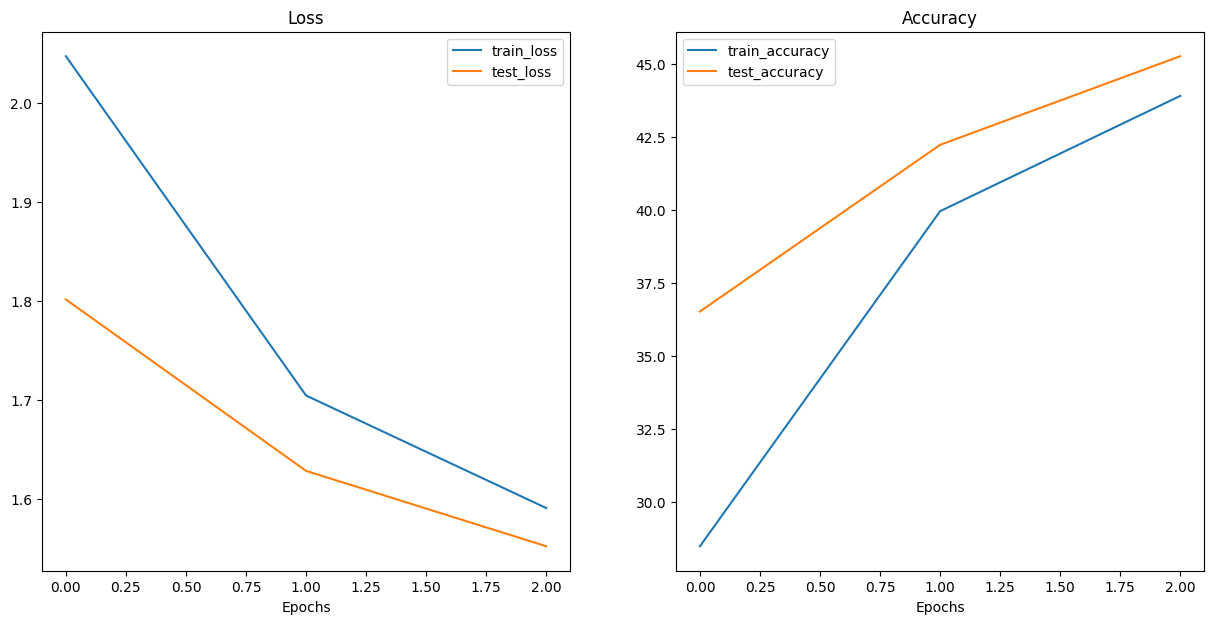

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_1_4)

# ***Model_1_5 (4 layers and lr=0,1)***

In [ ]:
# Input parameters
Model_1_5 = CIFAR10ModelV1_3(input_shape=3072,
    hidden_units_1 = 128,
    hidden_units_2 = 64,
    hidden_units_3 = 32,
    output_shape=len(class_names)
)
Model_1_5.to(device) # moves to GPU, if it is avaibale

#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_1_5.parameters(), lr=0.1)
torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_1_5 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_1_5,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_5
    )
    test_step(data_loader=test_dataloader,
        model=Model_1_5,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_5
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.81724 | Train accuracy: 35.11%
Test loss: 1.62209 | Test accuracy: 41.95%

Epoch: 1
-------
Train loss: 1.52520 | Train accuracy: 45.49%
Test loss: 1.50005 | Test accuracy: 47.01%

Epoch: 2
-------
Train loss: 1.42531 | Train accuracy: 49.49%
Test loss: 1.48425 | Test accuracy: 47.68%



In [ ]:
# Results of Model_1_5
Model_1_5_results = eval_model(model=Model_1_5, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_1_5_results

{'model_name': 'CIFAR10ModelV1_3',
 'model_loss': 1.484251856803894,
 'model_acc': 47.683703899383545}

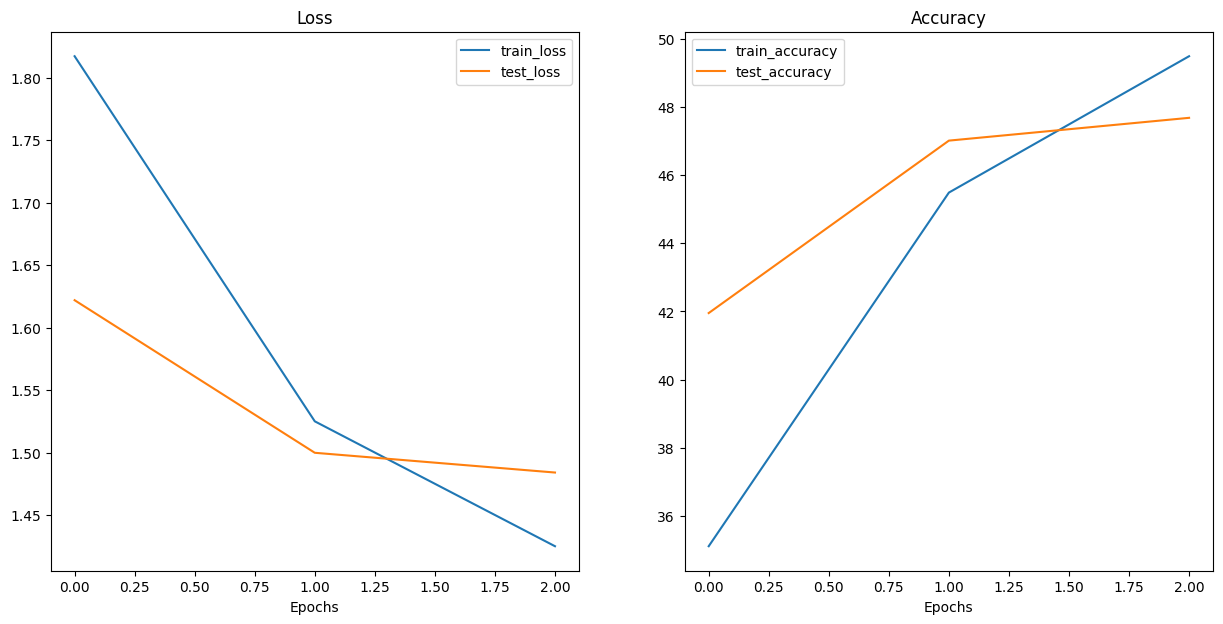

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_1_5)

# ***Model_1_6 (4 layers and lr=0,01)***

In [ ]:
# Input parameters
Model_1_6 = CIFAR10ModelV1_3(input_shape=3072,
    hidden_units_1 = 128,
    hidden_units_2 = 64,
    hidden_units_3 = 32,
    output_shape=len(class_names)
)
Model_1_6.to(device) # moves to GPU, if it is avaibale

#Accuracy, loss function, optimizer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_1_6.parameters(), lr=0.01)
torch.manual_seed(42) # this is necessary to ensure reproducibility (random numbers should be consistent)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_1_6 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3 # How many epochs for learning?

# Use of the functions (training and testing loopok)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_1_6,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_6
    )
    test_step(data_loader=test_dataloader,
        model=Model_1_6,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_1_6
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 2.24781 | Train accuracy: 18.42%
Test loss: 2.14923 | Test accuracy: 22.75%

Epoch: 1
-------
Train loss: 2.02229 | Train accuracy: 28.86%
Test loss: 1.87873 | Test accuracy: 34.87%

Epoch: 2
-------
Train loss: 1.80007 | Train accuracy: 38.10%
Test loss: 1.72392 | Test accuracy: 41.46%



In [ ]:
# Results of Model_1_6
Model_1_6_results = eval_model(model=Model_1_6, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_1_6_results

{'model_name': 'CIFAR10ModelV1_3',
 'model_loss': 1.7239235639572144,
 'model_acc': 41.46365821361542}

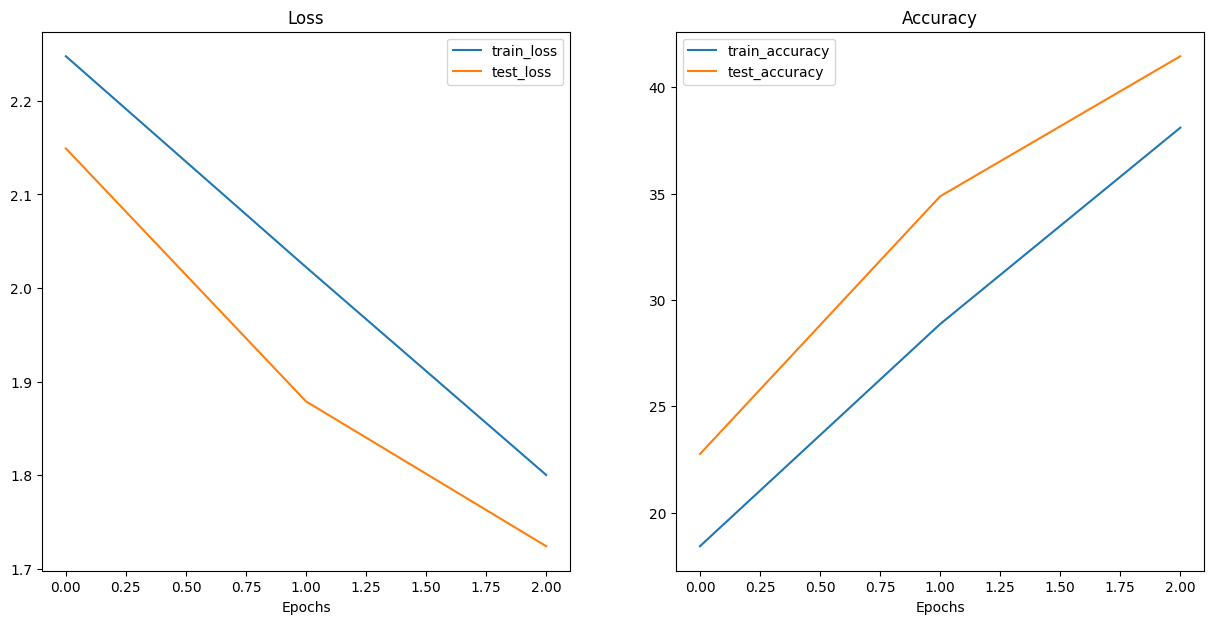

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_1_6)

# ***Comparing the results of Model_1***

In [ ]:
compare_results = pd.DataFrame([Model_1_1_results, Model_1_2_results, Model_1_3_results, Model_1_4_results, Model_1_5_results, Model_1_6_results])
compare_results

,model_name,model_loss,model_acc
0,CIFAR10ModelV1_1,1.727310,40.525159
1,CIFAR10ModelV1_1,1.558537,45.646966
2,CIFAR10ModelV1_2,1.481519,47.374201
3,CIFAR10ModelV1_2,1.552669,45.257586
4,CIFAR10ModelV1_3,1.484252,47.683704
5,CIFAR10ModelV1_3,1.723924,41.463658


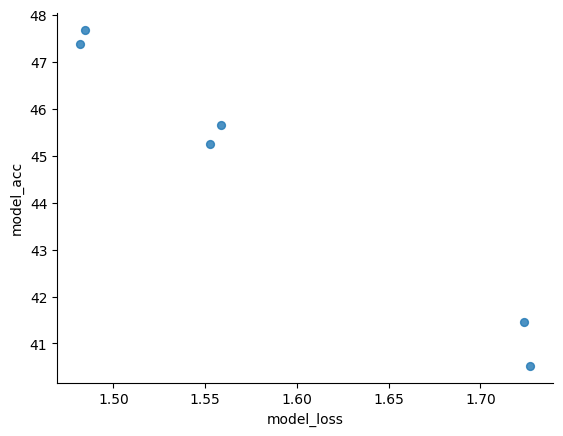

In [ ]:
compare_results.plot(kind='scatter', x='model_loss', y='model_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

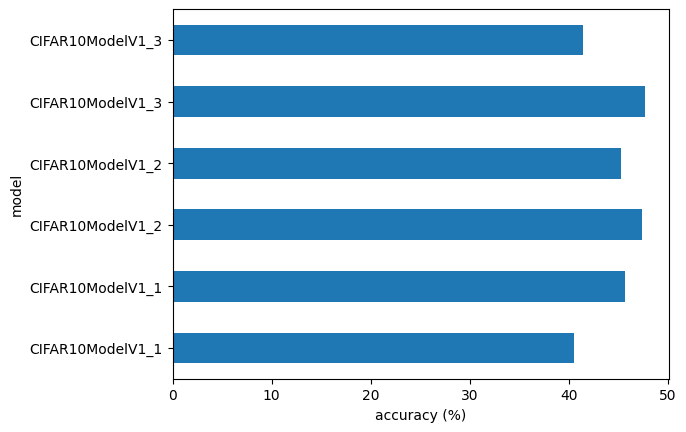

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

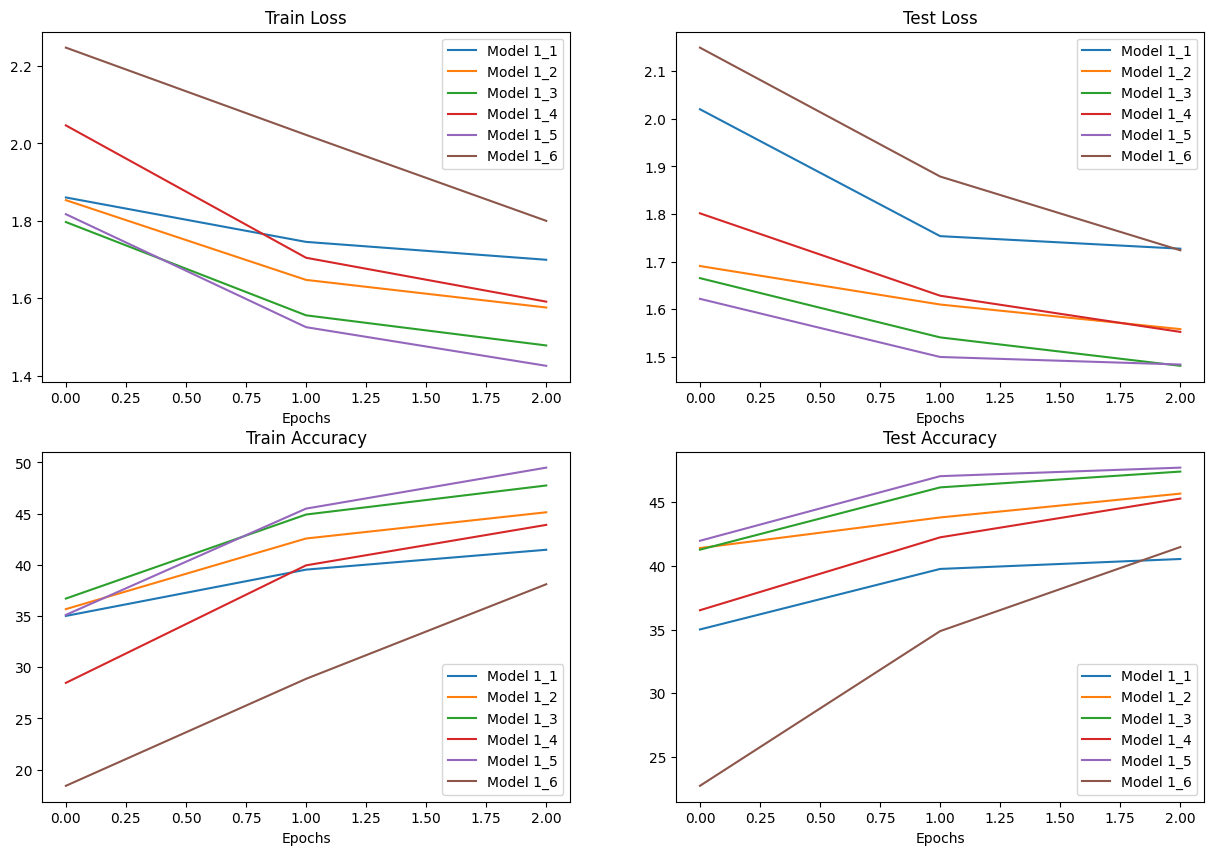

In [ ]:
# Recursively moving tensors in nested structures to the CPU
def move_to_cpu(x):
  if isinstance(x, torch.Tensor):
    return x.cpu().numpy()
  elif isinstance(x, (list, tuple)):
    return type(x)(move_to_cpu(item) for item in x)
  elif isinstance(x, dict):
    return {k: move_to_cpu(v) for k, v in x.items()}
  else:
    return x

Model_1_1_df = pd.DataFrame(move_to_cpu(results_1_1)) # Applying the function for moving here
Model_1_2_df = pd.DataFrame(move_to_cpu(results_1_2))
Model_1_3_df = pd.DataFrame(move_to_cpu(results_1_3))
Model_1_4_df = pd.DataFrame(move_to_cpu(results_1_4))
Model_1_5_df = pd.DataFrame(move_to_cpu(results_1_5))
Model_1_6_df = pd.DataFrame(move_to_cpu(results_1_6))

# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(Model_0_1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, Model_1_1_df["train_loss"], label="Model 1_1")
plt.plot(epochs, Model_1_2_df["train_loss"], label="Model 1_2")
plt.plot(epochs, Model_1_3_df["train_loss"], label="Model 1_3")
plt.plot(epochs, Model_1_4_df["train_loss"], label="Model 1_4")
plt.plot(epochs, Model_1_5_df["train_loss"], label="Model 1_5")
plt.plot(epochs, Model_1_6_df["train_loss"], label="Model 1_6")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, Model_1_1_df["test_loss"], label="Model 1_1")
plt.plot(epochs, Model_1_2_df["test_loss"], label="Model 1_2")
plt.plot(epochs, Model_1_3_df["test_loss"], label="Model 1_3")
plt.plot(epochs, Model_1_4_df["test_loss"], label="Model 1_4")
plt.plot(epochs, Model_1_5_df["test_loss"], label="Model 1_5")
plt.plot(epochs, Model_1_6_df["test_loss"], label="Model 1_6")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, Model_1_1_df["train_acc"], label="Model 1_1")
plt.plot(epochs, Model_1_2_df["train_acc"], label="Model 1_2")
plt.plot(epochs, Model_1_3_df["train_acc"], label="Model 1_3")
plt.plot(epochs, Model_1_4_df["train_acc"], label="Model 1_4")
plt.plot(epochs, Model_1_5_df["train_acc"], label="Model 1_5")
plt.plot(epochs, Model_1_6_df["train_acc"], label="Model 1_6")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, Model_1_1_df["test_acc"], label="Model 1_1")
plt.plot(epochs, Model_1_2_df["test_acc"], label="Model 1_2")
plt.plot(epochs, Model_1_3_df["test_acc"], label="Model 1_3")
plt.plot(epochs, Model_1_4_df["test_acc"], label="Model 1_4")
plt.plot(epochs, Model_1_5_df["test_acc"], label="Model 1_5")
plt.plot(epochs, Model_1_6_df["test_acc"], label="Model 1_6")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# ***Model_2 (CNN)***
Convolutional neural network with 64 neurons and a learning rate of 0,1

Testing 6 different cases, then analyzing the results

kernel_size - stride combinations: [3-1]; [5-1]; [3-2]; [5-2]; [7-2]; [3-3]

In [ ]:
class CIFAR10ModelV2_1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number ((kernel_size-1)/2)
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Dynamically calculate in_features using a dummy input
            nn.Linear(in_features=self._get_linear_input_size(input_shape),
                      out_features=output_shape)
        )

    def _get_linear_input_size(self, input_shape): # Calculates the input size for the linear layer using a dummy input.
        dummy_input = torch.randn(1, input_shape, 32, 32) # Assuming input size is 32x32
        output = self.block_1(dummy_input)
        output = self.block_2(output)
        output = torch.flatten(output, 1)
        return output.shape[1]

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

class CIFAR10ModelV2_2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=5, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=2),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Dynamically calculate in_features using a dummy input
            nn.Linear(in_features=self._get_linear_input_size(input_shape),
                      out_features=output_shape)
        )

    def _get_linear_input_size(self, input_shape): # Calculates the input size for the linear layer using a dummy input.
        dummy_input = torch.randn(1, input_shape, 32, 32) # Assuming input size is 32x32
        output = self.block_1(dummy_input)
        output = self.block_2(output)
        output = torch.flatten(output, 1)
        return output.shape[1]

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

class CIFAR10ModelV2_3(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=2, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=2,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=1) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Dynamically calculate in_features using a dummy input
            nn.Linear(in_features=self._get_linear_input_size(input_shape),
                      out_features=output_shape)
        )

    def _get_linear_input_size(self, input_shape): # Calculates the input size for the linear layer using a dummy input.
        dummy_input = torch.randn(1, input_shape, 32, 32) # Assuming input size is 32x32
        output = self.block_1(dummy_input)
        output = self.block_2(output)
        output = torch.flatten(output, 1)
        return output.shape[1]

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

class CIFAR10ModelV2_4(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=5, # how big is the square that's going over the image?
                      stride=2, # default
                      padding=2),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=5,
                      stride=2,
                      padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=1) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Dynamically calculate in_features using a dummy input
            nn.Linear(in_features=self._get_linear_input_size(input_shape),
                      out_features=output_shape)
        )

    def _get_linear_input_size(self, input_shape): # Calculates the input size for the linear layer using a dummy input.
        dummy_input = torch.randn(1, input_shape, 32, 32) # Assuming input size is 32x32
        output = self.block_1(dummy_input)
        output = self.block_2(output)
        output = torch.flatten(output, 1)
        return output.shape[1]

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

class CIFAR10ModelV2_5(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=7, # how big is the square that's going over the image?
                      stride=2, # default
                      padding=3),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=7,
                      stride=2,
                      padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=1) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Dynamically calculate in_features using a dummy input
            nn.Linear(in_features=self._get_linear_input_size(input_shape),
                      out_features=output_shape)
        )

    def _get_linear_input_size(self, input_shape): # Calculates the input size for the linear layer using a dummy input.
        dummy_input = torch.randn(1, input_shape, 32, 32) # Assuming input size is 32x32
        output = self.block_1(dummy_input)
        output = self.block_2(output)
        output = torch.flatten(output, 1)
        return output.shape[1]

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

class CIFAR10ModelV2_6(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=7, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=3),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=7,
                      stride=1,
                      padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=1) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Dynamically calculate in_features using a dummy input
            nn.Linear(in_features=self._get_linear_input_size(input_shape),
                      out_features=output_shape)
        )

    def _get_linear_input_size(self, input_shape): # Calculates the input size for the linear layer using a dummy input.
        dummy_input = torch.randn(1, input_shape, 32, 32) # Assuming input size is 32x32
        output = self.block_1(dummy_input)
        output = self.block_2(output)
        output = torch.flatten(output, 1)
        return output.shape[1]

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# ***Model_2_1 [3-1]***

In [ ]:
Model_2_1 = CIFAR10ModelV2_1(input_shape=3,   # RGB imgages: input_shape=3; greyscale images: input_shape=1
    hidden_units=64,
    output_shape=len(class_names)
)
Model_2_1.to(device) # moves to GPU, if it is avaiable

#Accuracy, loss function, optimezer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_2_1.parameters(), lr=0.1)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_2_1 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_2_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_1
    )
    test_step(data_loader=test_dataloader,
        model=Model_2_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_1
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.50455 | Train accuracy: 46.07%
Test loss: 1.23362 | Test accuracy: 56.80%

Epoch: 1
-------
Train loss: 0.97578 | Train accuracy: 65.84%
Test loss: 1.16539 | Test accuracy: 60.40%

Epoch: 2
-------
Train loss: 0.78369 | Train accuracy: 72.72%
Test loss: 0.85960 | Test accuracy: 70.58%



In [ ]:
# Results of Model_2_1
Model_2_1_results = eval_model(model=Model_2_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_2_1_results

{'model_name': 'CIFAR10ModelV2_1',
 'model_loss': 0.859603226184845,
 'model_acc': 70.577073097229}

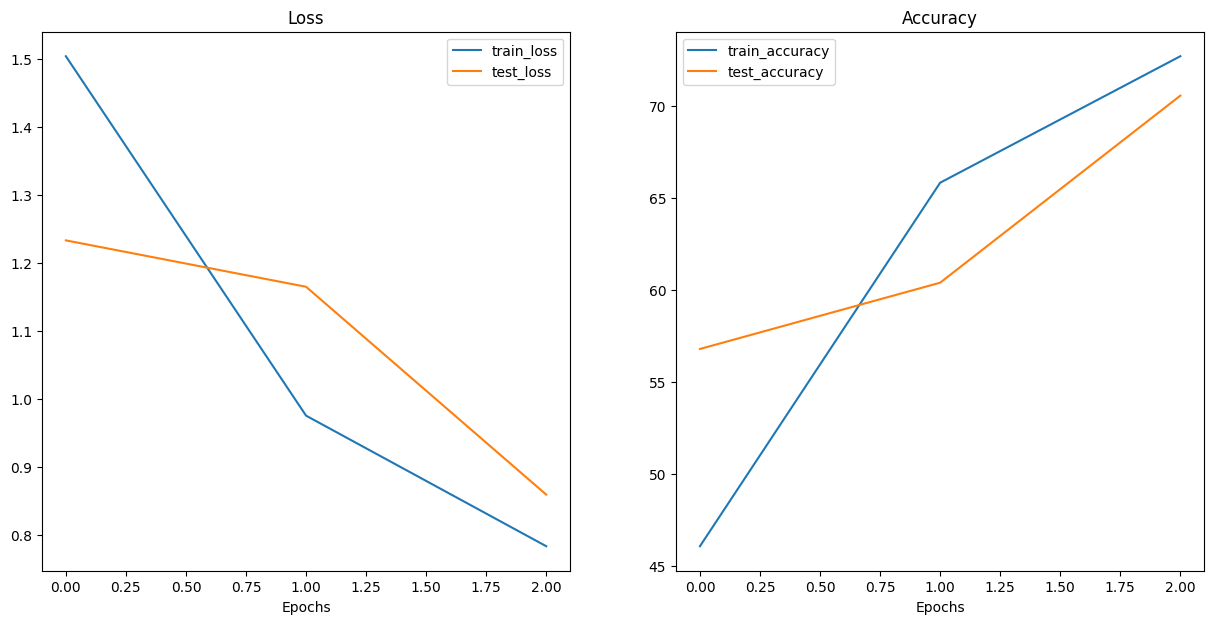

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_2_1)

# ***Model_2_2 [5-1]***

In [ ]:
Model_2_2 = CIFAR10ModelV2_2(input_shape=3,   # RGB imgages: input_shape=3; greyscale images: input_shape=1
    hidden_units=64,
    output_shape=len(class_names)
)
Model_2_2.to(device) # moves to GPU, if it is avaiable

#Accuracy, loss function, optimezer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_2_2.parameters(), lr=0.1)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_2_2 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_2_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_2
    )
    test_step(data_loader=test_dataloader,
        model=Model_2_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_2
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.60156 | Train accuracy: 42.10%
Test loss: 1.28359 | Test accuracy: 54.58%

Epoch: 1
-------
Train loss: 1.03383 | Train accuracy: 63.82%
Test loss: 1.09022 | Test accuracy: 61.67%

Epoch: 2
-------
Train loss: 0.83123 | Train accuracy: 70.98%
Test loss: 0.99653 | Test accuracy: 66.43%



In [ ]:
# Results of Model_2_2
Model_2_2_results = eval_model(model=Model_2_2, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_2_2_results

{'model_name': 'CIFAR10ModelV2_2',
 'model_loss': 0.9965340495109558,
 'model_acc': 66.43370389938354}

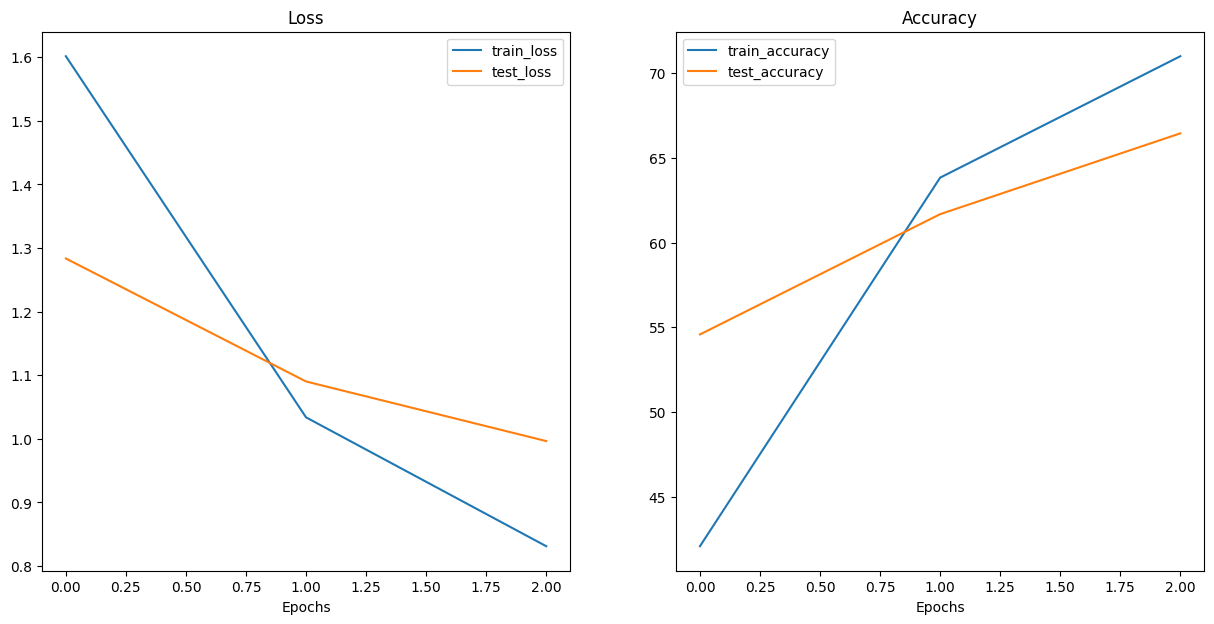

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_2_2)

# ***Model_2_3 [3-2]***

In [ ]:
Model_2_3 = CIFAR10ModelV2_3(input_shape=3,   # RGB imgages: input_shape=3; greyscale images: input_shape=1
    hidden_units=64,
    output_shape=len(class_names)
)
Model_2_3.to(device) # moves to GPU, if it is avaiable

#Accuracy, loss function, optimezer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_2_3.parameters(), lr=0.1)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_2_3 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_2_3,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_3
    )
    test_step(data_loader=test_dataloader,
        model=Model_2_3,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_3
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.68227 | Train accuracy: 38.76%
Test loss: 1.39085 | Test accuracy: 48.26%

Epoch: 1
-------
Train loss: 1.24020 | Train accuracy: 55.49%
Test loss: 1.26139 | Test accuracy: 54.99%

Epoch: 2
-------
Train loss: 1.04093 | Train accuracy: 63.15%
Test loss: 0.97136 | Test accuracy: 66.28%



In [ ]:
# Results of Model_2_3
Model_2_3_results = eval_model(model=Model_2_3, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_2_3_results

{'model_name': 'CIFAR10ModelV2_3',
 'model_loss': 0.9713638424873352,
 'model_acc': 66.28394722938538}

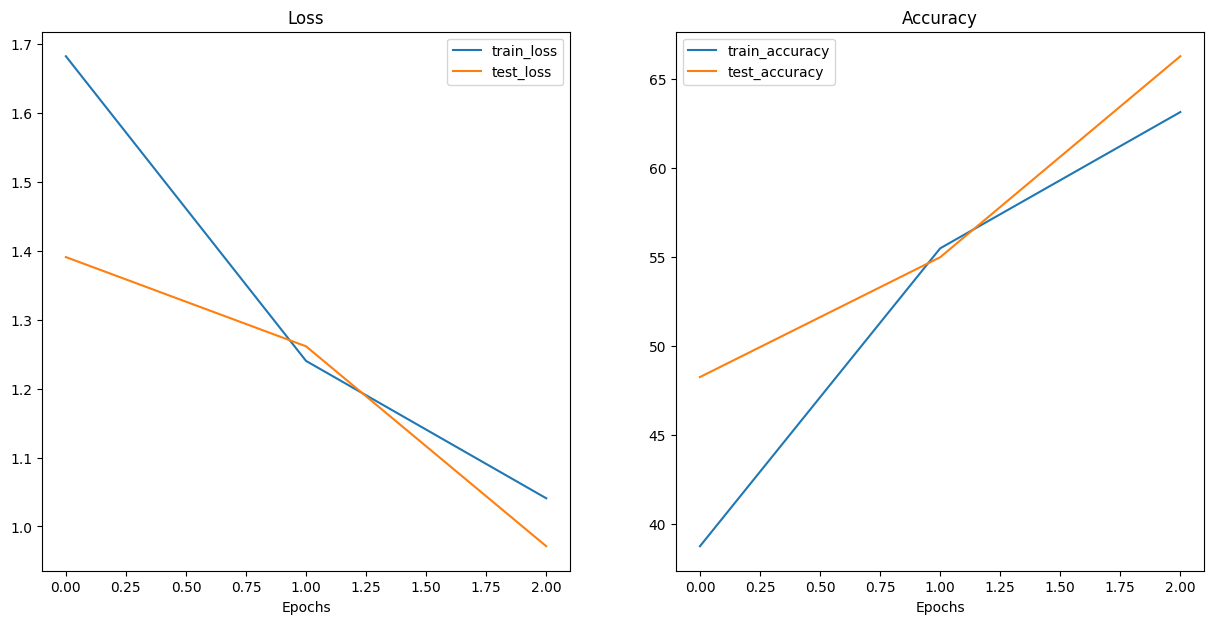

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_2_3)

# ***Model_2_4 [5-2]***

In [ ]:
Model_2_4 = CIFAR10ModelV2_4(input_shape=3,   # RGB imgages: input_shape=3; greyscale images: input_shape=1
    hidden_units=64,
    output_shape=len(class_names)
)
Model_2_4.to(device) # moves to GPU, if it is avaiable

#Accuracy, loss function, optimezer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_2_4.parameters(), lr=0.1)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_2_4 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_2_4,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_4
    )
    test_step(data_loader=test_dataloader,
        model=Model_2_4,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_4
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.64155 | Train accuracy: 39.78%
Test loss: 1.42014 | Test accuracy: 47.92%

Epoch: 1
-------
Train loss: 1.19241 | Train accuracy: 57.54%
Test loss: 1.24911 | Test accuracy: 54.38%

Epoch: 2
-------
Train loss: 0.98418 | Train accuracy: 65.34%
Test loss: 1.03254 | Test accuracy: 64.84%



In [ ]:
# Results of Model_2_4
Model_2_4_results = eval_model(model=Model_2_4, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_2_4_results

{'model_name': 'CIFAR10ModelV2_4',
 'model_loss': 1.0325448513031006,
 'model_acc': 64.83626365661621}

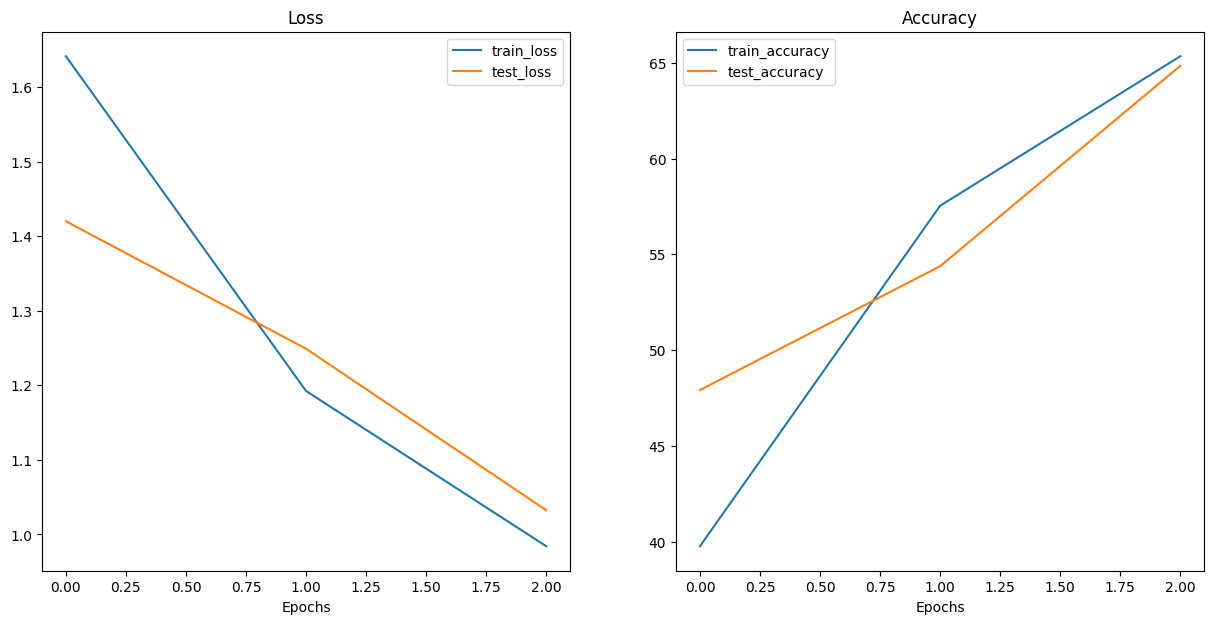

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_2_4)

# ***Model_2_5 [7-2]***

In [ ]:
Model_2_5 = CIFAR10ModelV2_5(input_shape=3,   # RGB imgages: input_shape=3; greyscale images: input_shape=1
    hidden_units=64,
    output_shape=len(class_names)
)
Model_2_5.to(device) # moves to GPU, if it is avaiable

#Accuracy, loss function, optimezer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_2_5.parameters(), lr=0.1)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_2_5 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_2_5,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_5
    )
    test_step(data_loader=test_dataloader,
        model=Model_2_5,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_5
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.64918 | Train accuracy: 39.71%
Test loss: 1.36197 | Test accuracy: 50.55%

Epoch: 1
-------
Train loss: 1.20126 | Train accuracy: 57.08%
Test loss: 1.21493 | Test accuracy: 56.81%

Epoch: 2
-------
Train loss: 0.99914 | Train accuracy: 65.10%
Test loss: 1.13137 | Test accuracy: 61.32%



In [ ]:
# Results of Model_2_5
Model_2_5_results = eval_model(model=Model_2_5, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_2_5_results

{'model_name': 'CIFAR10ModelV2_5',
 'model_loss': 1.131370186805725,
 'model_acc': 61.32188439369202}

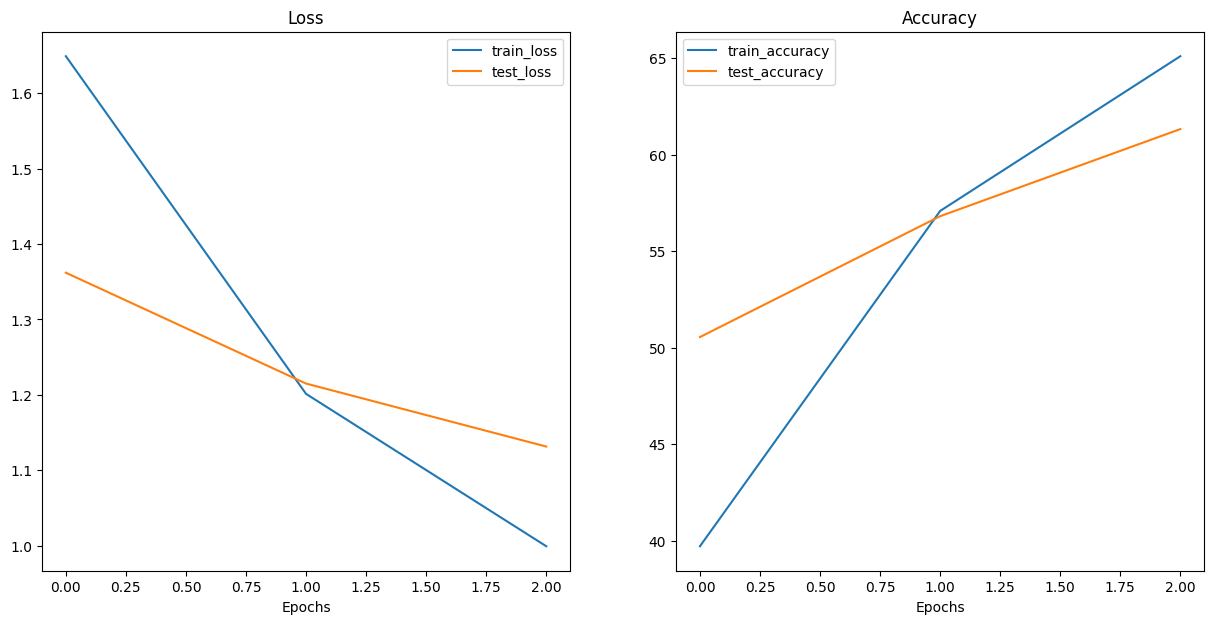

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_2_5)

# ***Model_2_6 [7-1]***

In [ ]:
Model_2_6 = CIFAR10ModelV2_6(input_shape=3,   # RGB imgages: input_shape=3; greyscale images: input_shape=1
    hidden_units=64,
    output_shape=len(class_names)
)
Model_2_6.to(device) # moves to GPU, if it is avaiable

#Accuracy, loss function, optimezer

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_2_6.parameters(), lr=0.1)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

results_2_6 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(data_loader=train_dataloader,
        model=Model_2_6,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_6
    )
    test_step(data_loader=test_dataloader,
        model=Model_2_6,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
        results=results_2_6
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.73409 | Train accuracy: 37.04%
Test loss: 1.42589 | Test accuracy: 47.65%

Epoch: 1
-------
Train loss: 1.31391 | Train accuracy: 52.78%
Test loss: 1.29960 | Test accuracy: 53.18%

Epoch: 2
-------
Train loss: 1.13542 | Train accuracy: 59.74%
Test loss: 1.08544 | Test accuracy: 61.56%



In [ ]:
# Results of Model_2_6
Model_2_6_results = eval_model(model=Model_2_6, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device
)
Model_2_6_results

{'model_name': 'CIFAR10ModelV2_6',
 'model_loss': 1.0854443311691284,
 'model_acc': 61.561501026153564}

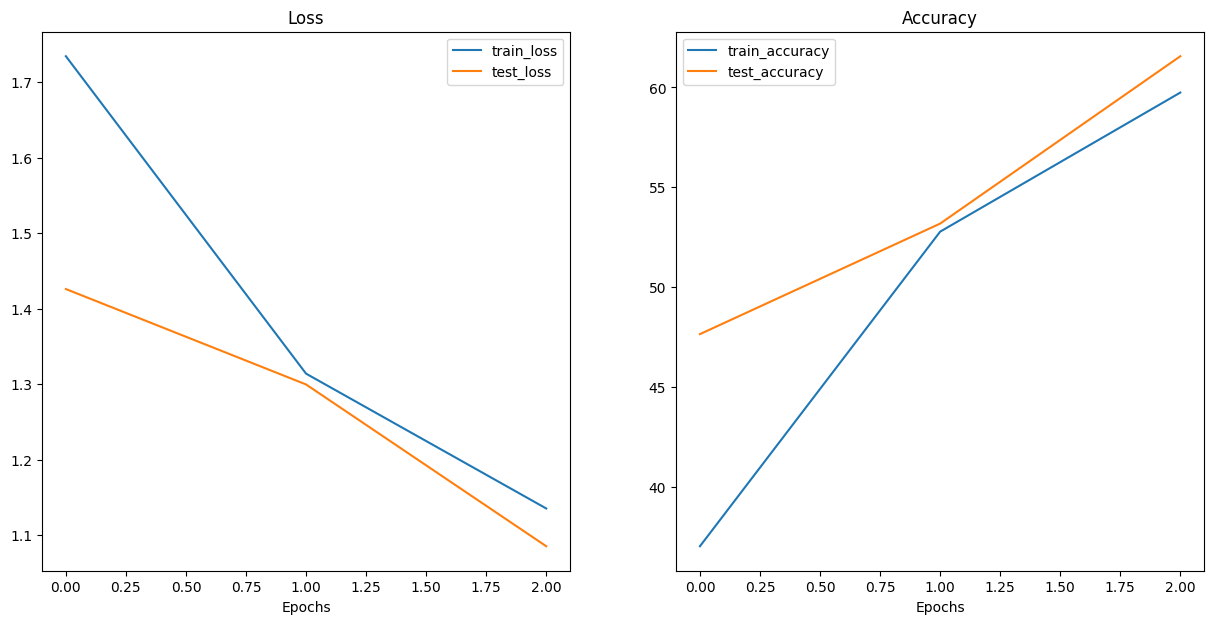

In [ ]:
# Plot loss and accuracy curves
plot_curves(results=results_2_6)

# ***Comparing the results of Model_2***

In [ ]:
compare_results = pd.DataFrame([Model_2_1_results, Model_2_2_results, Model_2_3_results, Model_2_4_results, Model_2_5_results, Model_2_6_results])
compare_results

,model_name,model_loss,model_acc
0,CIFAR10ModelV2_1,0.859603,70.577073
1,CIFAR10ModelV2_2,0.996534,66.433704
2,CIFAR10ModelV2_3,0.971364,66.283947
3,CIFAR10ModelV2_4,1.032545,64.836264
4,CIFAR10ModelV2_5,1.131370,61.321884
5,CIFAR10ModelV2_6,1.085444,61.561501


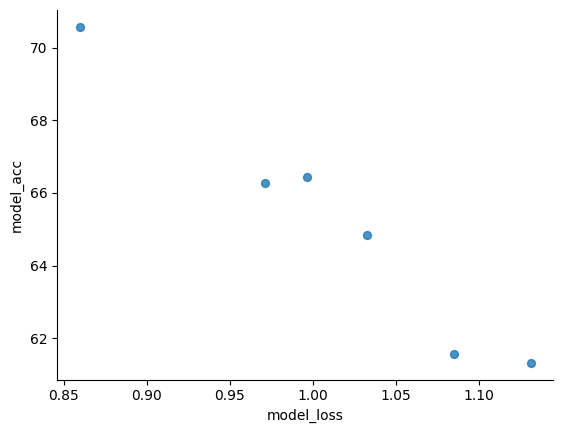

In [ ]:
compare_results.plot(kind='scatter', x='model_loss', y='model_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

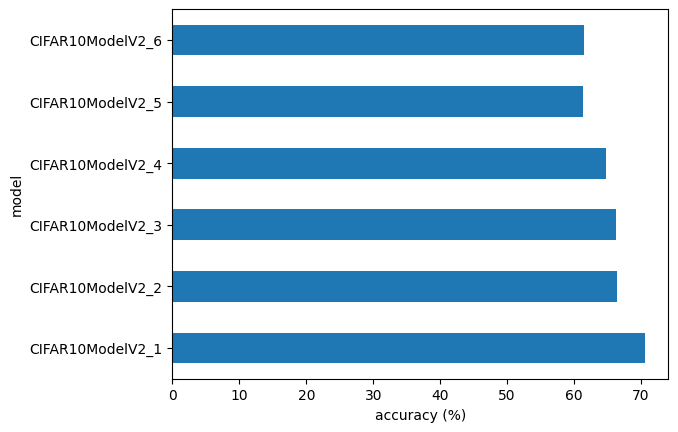

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

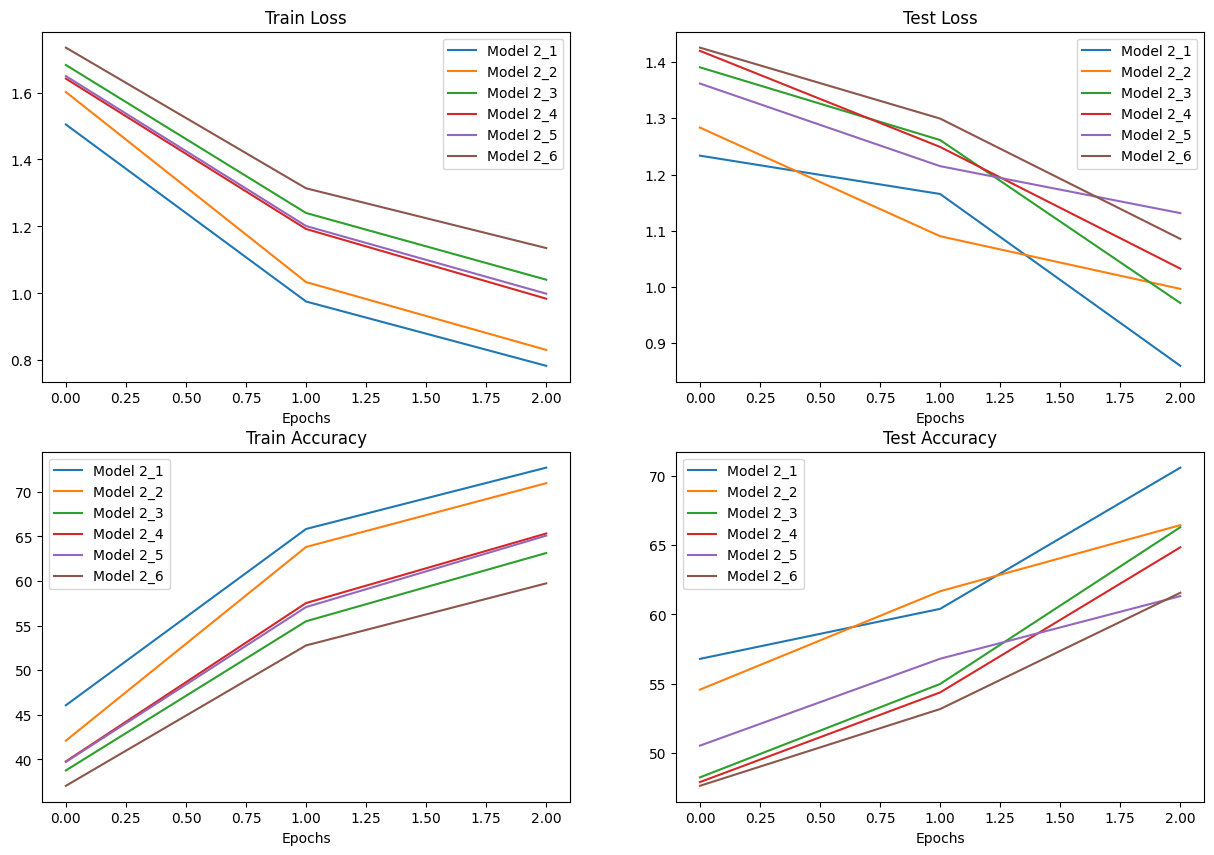

In [ ]:
# Recursively moving tensors in nested structures to the CPU
def move_to_cpu(x):
  if isinstance(x, torch.Tensor):
    return x.cpu().numpy()
  elif isinstance(x, (list, tuple)):
    return type(x)(move_to_cpu(item) for item in x)
  elif isinstance(x, dict):
    return {k: move_to_cpu(v) for k, v in x.items()}
  else:
    return x

Model_2_1_df = pd.DataFrame(move_to_cpu(results_2_1)) # Applying the function for moving here
Model_2_2_df = pd.DataFrame(move_to_cpu(results_2_2))
Model_2_3_df = pd.DataFrame(move_to_cpu(results_2_3))
Model_2_4_df = pd.DataFrame(move_to_cpu(results_2_4))
Model_2_5_df = pd.DataFrame(move_to_cpu(results_2_5))
Model_2_6_df = pd.DataFrame(move_to_cpu(results_2_6))

# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(Model_0_1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, Model_2_1_df["train_loss"], label="Model 2_1")
plt.plot(epochs, Model_2_2_df["train_loss"], label="Model 2_2")
plt.plot(epochs, Model_2_3_df["train_loss"], label="Model 2_3")
plt.plot(epochs, Model_2_4_df["train_loss"], label="Model 2_4")
plt.plot(epochs, Model_2_5_df["train_loss"], label="Model 2_5")
plt.plot(epochs, Model_2_6_df["train_loss"], label="Model 2_6")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, Model_2_1_df["test_loss"], label="Model 2_1")
plt.plot(epochs, Model_2_2_df["test_loss"], label="Model 2_2")
plt.plot(epochs, Model_2_3_df["test_loss"], label="Model 2_3")
plt.plot(epochs, Model_2_4_df["test_loss"], label="Model 2_4")
plt.plot(epochs, Model_2_5_df["test_loss"], label="Model 2_5")
plt.plot(epochs, Model_2_6_df["test_loss"], label="Model 2_6")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, Model_2_1_df["train_acc"], label="Model 2_1")
plt.plot(epochs, Model_2_2_df["train_acc"], label="Model 2_2")
plt.plot(epochs, Model_2_3_df["train_acc"], label="Model 2_3")
plt.plot(epochs, Model_2_4_df["train_acc"], label="Model 2_4")
plt.plot(epochs, Model_2_5_df["train_acc"], label="Model 2_5")
plt.plot(epochs, Model_2_6_df["train_acc"], label="Model 2_6")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, Model_2_1_df["test_acc"], label="Model 2_1")
plt.plot(epochs, Model_2_2_df["test_acc"], label="Model 2_2")
plt.plot(epochs, Model_2_3_df["test_acc"], label="Model 2_3")
plt.plot(epochs, Model_2_4_df["test_acc"], label="Model 2_4")
plt.plot(epochs, Model_2_5_df["test_acc"], label="Model 2_5")
plt.plot(epochs, Model_2_6_df["test_acc"], label="Model 2_6")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# ***Comparing the best results from each model***



In [ ]:
compare_results = pd.DataFrame([Model_0_4_results, Model_1_5_results, Model_2_1_results])
compare_results

,model_name,model_loss,model_acc
0,CIFAR10ModelV0,1.720832,40.714857
1,CIFAR10ModelV1_3,1.484252,47.683704
2,CIFAR10ModelV2_1,0.859603,70.577073


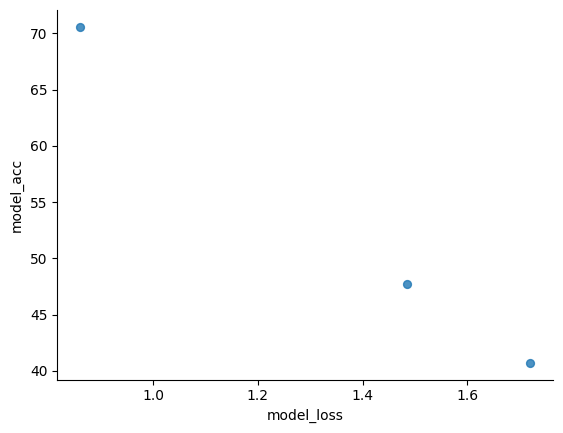

In [ ]:
compare_results.plot(kind='scatter', x='model_loss', y='model_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

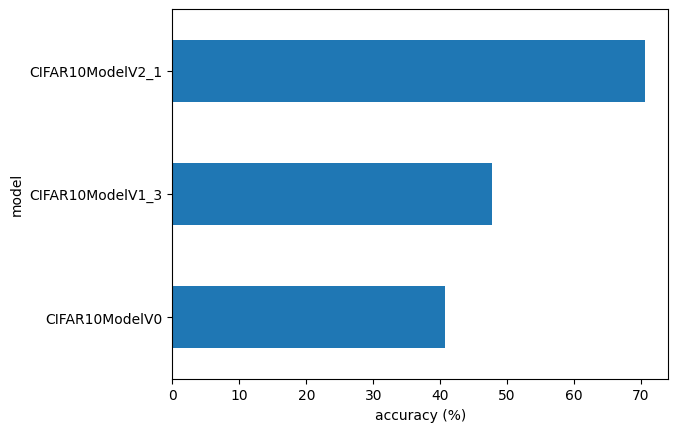

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

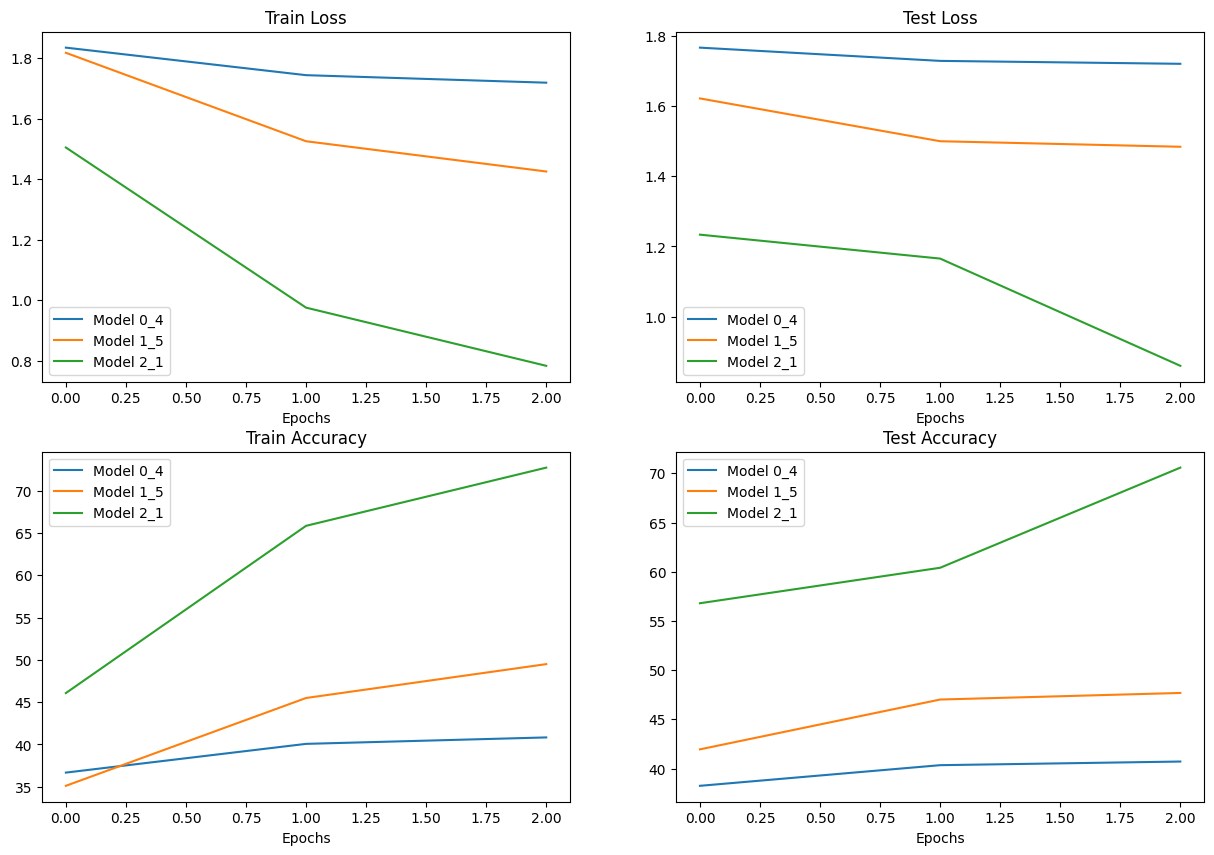

In [ ]:
# Recursively moving tensors in nested structures to the CPU
def move_to_cpu(x):
  if isinstance(x, torch.Tensor):
    return x.cpu().numpy()
  elif isinstance(x, (list, tuple)):
    return type(x)(move_to_cpu(item) for item in x)
  elif isinstance(x, dict):
    return {k: move_to_cpu(v) for k, v in x.items()}
  else:
    return x

Model_0_4_df = pd.DataFrame(move_to_cpu(results_0_4)) # Applying the function for moving here
Model_1_5_df = pd.DataFrame(move_to_cpu(results_1_5))
Model_2_1_df = pd.DataFrame(move_to_cpu(results_2_1))

# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(Model_0_4_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, Model_0_4_df["train_loss"], label="Model 0_4")
plt.plot(epochs, Model_1_5_df["train_loss"], label="Model 1_5")
plt.plot(epochs, Model_2_1_df["train_loss"], label="Model 2_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, Model_0_4_df["test_loss"], label="Model 0_4")
plt.plot(epochs, Model_1_5_df["test_loss"], label="Model 1_5")
plt.plot(epochs, Model_2_1_df["test_loss"], label="Model 2_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, Model_0_4_df["train_acc"], label="Model 0_4")
plt.plot(epochs, Model_1_5_df["train_acc"], label="Model 1_5")
plt.plot(epochs, Model_2_1_df["train_acc"], label="Model 2_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, Model_0_4_df["test_acc"], label="Model 0_4")
plt.plot(epochs, Model_1_5_df["test_acc"], label="Model 1_5")
plt.plot(epochs, Model_2_1_df["test_acc"], label="Model 2_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# ***Evaluate the best performing model (Model_2_1)***

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass
            pred_logit = model(sample)

            # Get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 9 (truck)


In [ ]:
pred_probs= make_predictions(model=Model_2_1, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes
test_labels, pred_classes

([9, 2, 1, 3, 7, 3, 7, 0, 9], tensor([9, 2, 1, 9, 7, 7, 7, 0, 1]))

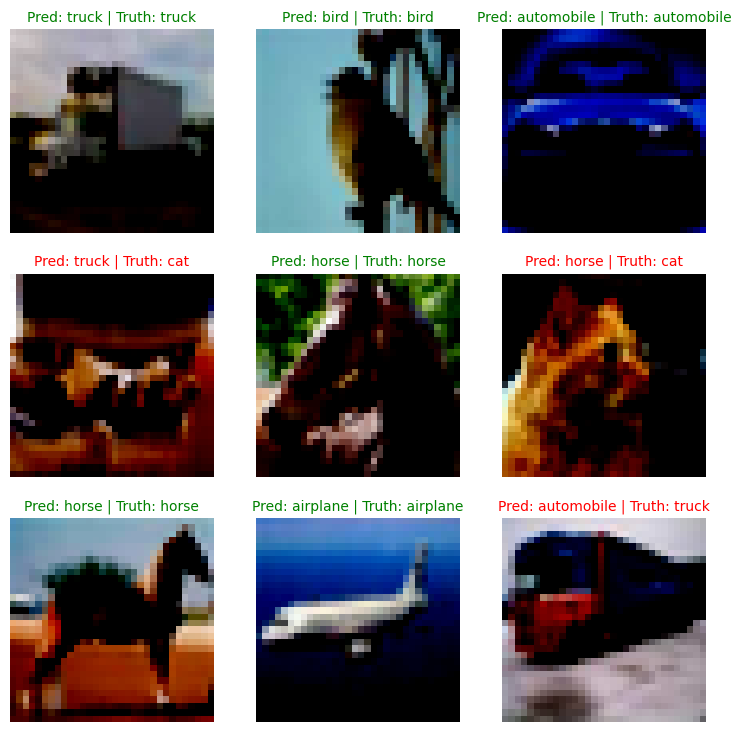

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0))

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

mlxtend version: 0.23.3


Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

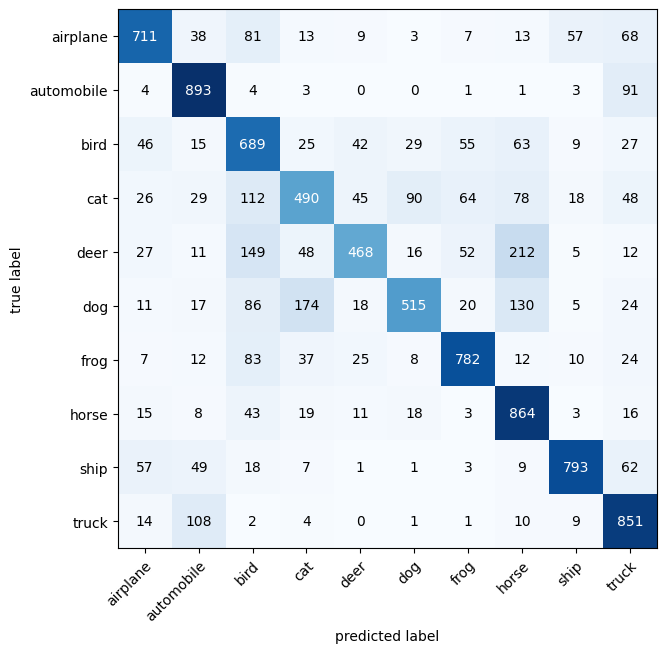

In [ ]:
# Confusion matrix
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")


# 1. Make predictions with trained model
y_preds = []
Model_2_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = Model_2_1(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
target_tensor = torch.tensor(test_data.targets)
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=target_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);